In [347]:
import dask.dataframe as dd
import time
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.stats import mstats
#from progressbar import *
import matplotlib.pyplot as plt
import os
import gc

In [6]:
if not os.path.exists('./Stats_Detail_New/'):
    os.makedirs('./Stats_Detail_New/')
if not os.path.exists('./Weight/'):
    os.makedirs('./Weight/')
if not os.path.exists('./Graph_new/'):
    os.makedirs('./Graph_new/')
if not os.path.exists('./stats/'):
    os.makedirs('./stats/')

In [9]:
Factor_args = {}
#tri -> 排序權重法
Factor_args['weight_method'] = ['tri']
tir_list = [x for x in Factor_args['weight_method'] if 'tri' in x]
Factor_args['weight_method'] = Factor_args['weight_method'] + [x + '_value' for x in tir_list]

In [15]:
Factor_args

{'weight_method': ['tri', 'tri_value'],
 'upper_lower_perc_eq': {'upper': 0.1, 'lower': 0.9},
 'upper_lower_perc_tri': {'upper': 0.5, 'lower': 0.5},
 'PE': {'factors': [], 'longbig': [], 'periods': []}}

In [13]:
Main_Factor_Name = 'PE'
Main_Factor_Long = 0
periods = 1

In [14]:
#eq:平均權重法 -> long/short因子最大的10%，short/long因子最小的10%(90%)
#tri:排序權重法 -> 以中位數切割，排序並給予權重
Factor_args['upper_lower_perc_eq'] =  { "upper" : 0.1,"lower" : 0.9 }
Factor_args['upper_lower_perc_tri'] =  { "upper" : 0.5,"lower" : 0.5 }
Factor_args[Main_Factor_Name] = { "factors" : [],
                                  "longbig" : [],
                                  "periods" : [] }

In [18]:
Factor_args[Main_Factor_Name]['factors'] = [Main_Factor_Name]
Factor_args[Main_Factor_Name]['longbig'] = [Main_Factor_Long] * len(Factor_args[Main_Factor_Name]['factors']) #1是多大的
Factor_args[Main_Factor_Name]['periods'] = [periods]

In [19]:
Factor_args

{'weight_method': ['tri', 'tri_value'],
 'upper_lower_perc_eq': {'upper': 0.1, 'lower': 0.9},
 'upper_lower_perc_tri': {'upper': 0.5, 'lower': 0.5},
 'PE': {'factors': ['PE'], 'longbig': [0], 'periods': [1]}}

# data

In [21]:
#using chunksize to load data (因為資料過大，利用這個分批載入)
reader = pd.read_csv('./Data/output/df_merge_1_new.txt', chunksize=10 ** 6)
reader

In [22]:
#ignore_index = True 以忽略合併時舊的index欄位，改採用自動產生的index
df_merge_final = pd.concat([x for x in reader], ignore_index = True)
df_merge_final

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm
0,1101,20070102,29.75,4092.0,NaN,934.6,2007,1.0,9055.41,0.012408
1,1101,20070103,29.45,4839.0,262595240.0,925.2,2007,1.0,9051.41,-0.000442
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174
3,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470
4,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617
...,...,...,...,...,...,...,...,...,...,...
6727271,9962,20190923,10.60,62.0,831716.0,9.6,2019,10.0,20319.98,-0.000975
6727272,9962,20190924,10.60,24.0,831932.0,9.6,2019,10.0,20318.25,-0.000085
6727273,9962,20190925,10.55,35.0,830044.0,9.5,2019,10.0,20235.92,-0.004052
6727274,9962,20190926,10.50,29.0,830756.0,9.5,2019,10.0,20233.00,-0.000144


In [23]:
df_merge_final.count()

Code             6727276
Date             6727276
Close            4593760
Volumn           4593527
Volumn_a_mean    4242522
CAP              4590628
Year             6727276
Ind              6727276
大盤指數             6727276
Rm               6727276
dtype: int64

In [24]:
factor = Factor_args[Main_Factor_Name]['factors'][0]
periods = Factor_args[Main_Factor_Name]['periods'][0]

In [27]:
reader = pd.read_csv('./Data/output/df_merge_2.txt', chunksize = 10 ** 6)
df_factor = pd.concat([x for x in reader], ignore_index = True)

In [29]:
df_factor[['Date', 'Code', factor]]

,Date,Code,PE
0,20070102,1101,13.5
1,20070103,1101,13.4
2,20070104,1101,13.3
3,20070105,1101,13.2
4,20070108,1101,13.2
...,...,...,...
6730419,20190923,9962,NaN
6730420,20190924,9962,NaN
6730421,20190925,9962,NaN
6730422,20190926,9962,NaN


In [32]:
#how = left -> 以left的index為準，只 merge兩者on(Date、Code)的交集
df_merge_final = pd.merge(left = df_merge_final, right = df_factor[['Date', 'Code', factor]], 
                         on = ['Date', 'Code'], how = 'left')
df_merge_final

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE
0,1101,20070102,29.75,4092.0,NaN,934.6,2007,1.0,9055.41,0.012408,13.5
1,1101,20070103,29.45,4839.0,262595240.0,925.2,2007,1.0,9051.41,-0.000442,13.4
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3
3,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470,13.2
4,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617,13.2
...,...,...,...,...,...,...,...,...,...,...,...
6727271,9962,20190923,10.60,62.0,831716.0,9.6,2019,10.0,20319.98,-0.000975,NaN
6727272,9962,20190924,10.60,24.0,831932.0,9.6,2019,10.0,20318.25,-0.000085,NaN
6727273,9962,20190925,10.55,35.0,830044.0,9.5,2019,10.0,20235.92,-0.004052,NaN
6727274,9962,20190926,10.50,29.0,830756.0,9.5,2019,10.0,20233.00,-0.000144,NaN


In [34]:
df_merge_final.count()

Code             6727276
Date             6727276
Close            4593760
Volumn           4593527
Volumn_a_mean    4242522
CAP              4590628
Year             6727276
Ind              6727276
大盤指數             6727276
Rm               6727276
PE               3801131
dtype: int64

In [35]:
del df_factor

In [36]:
#shift -> 向上或向下平移，缺少的值以NaN填補
df_merge_final.groupby('Code')['CAP'].shift(1)

0            NaN
1          934.6
2          925.2
3          922.1
4          912.6
           ...  
6727271      9.7
6727272      9.6
6727273      9.6
6727274      9.5
6727275      9.5
Name: CAP, Length: 6727276, dtype: float64

In [37]:
df_merge_final['CAP_t-1'] = df_merge_final.groupby('Code')['CAP'].shift(1)

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1
0,1101,20070102,29.75,4092.0,NaN,934.6,2007,1.0,9055.41,0.012408,13.5,NaN
1,1101,20070103,29.45,4839.0,262595240.0,925.2,2007,1.0,9051.41,-0.000442,13.4,934.6
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2
3,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470,13.2,922.1
4,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617,13.2,912.6
...,...,...,...,...,...,...,...,...,...,...,...,...
6727271,9962,20190923,10.60,62.0,831716.0,9.6,2019,10.0,20319.98,-0.000975,NaN,9.7
6727272,9962,20190924,10.60,24.0,831932.0,9.6,2019,10.0,20318.25,-0.000085,NaN,9.6
6727273,9962,20190925,10.55,35.0,830044.0,9.5,2019,10.0,20235.92,-0.004052,NaN,9.6
6727274,9962,20190926,10.50,29.0,830756.0,9.5,2019,10.0,20233.00,-0.000144,NaN,9.5


In [40]:
#main factor -> PE -> 計算T-1、T-2
factor_list = Factor_args[Main_Factor_Name]['factors']
for factor in factor_list :
    df_merge_final[factor+'_t-1']= df_merge_final.groupby('Code')[factor].shift(1)
    df_merge_final[factor+'_t-2']= df_merge_final.groupby('Code')[factor].shift(2)

In [42]:
# shift 收盤價方便計算投組損益
df_merge_final['Close_t+1'] = df_merge_final.groupby('Code')['Close'].shift(-1)
df_merge_final['Close_t-1'] = df_merge_final.groupby('Code')['Close'].shift(1)
df_merge_final

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1
0,1101,20070102,29.75,4092.0,NaN,934.6,2007,1.0,9055.41,0.012408,13.5,NaN,NaN,NaN,29.45,NaN
1,1101,20070103,29.45,4839.0,262595240.0,925.2,2007,1.0,9051.41,-0.000442,13.4,934.6,13.5,NaN,29.35,29.75
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45
3,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470,13.2,922.1,13.3,13.4,29.00,29.35
4,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617,13.2,912.6,13.2,13.3,30.25,29.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727271,9962,20190923,10.60,62.0,831716.0,9.6,2019,10.0,20319.98,-0.000975,NaN,9.7,NaN,NaN,10.60,10.70
6727272,9962,20190924,10.60,24.0,831932.0,9.6,2019,10.0,20318.25,-0.000085,NaN,9.6,NaN,NaN,10.55,10.60
6727273,9962,20190925,10.55,35.0,830044.0,9.5,2019,10.0,20235.92,-0.004052,NaN,9.6,NaN,NaN,10.50,10.60
6727274,9962,20190926,10.50,29.0,830756.0,9.5,2019,10.0,20233.00,-0.000144,NaN,9.5,NaN,NaN,10.40,10.55


In [45]:
#2007/01/04開始
np.array(df_merge_final['Date'].unique())[2]

20070104

In [46]:
# 調整開始時間
date_begin = np.array(df_merge_final['Date'].unique())[2]
df_merge_final = df_merge_final[df_merge_final['Date'] >= date_begin]
df_merge_final

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45
3,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470,13.2,922.1,13.3,13.4,29.00,29.35
4,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617,13.2,912.6,13.2,13.3,30.25,29.05
5,1101,20070109,30.25,10074.0,260225256.0,950.3,2007,1.0,8905.89,0.006890,13.7,911.1,13.2,13.2,29.75,29.00
6,1101,20070110,29.75,13399.0,259865000.0,934.6,2007,1.0,8801.28,-0.011746,13.5,950.3,13.7,13.2,29.05,30.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727271,9962,20190923,10.60,62.0,831716.0,9.6,2019,10.0,20319.98,-0.000975,NaN,9.7,NaN,NaN,10.60,10.70
6727272,9962,20190924,10.60,24.0,831932.0,9.6,2019,10.0,20318.25,-0.000085,NaN,9.6,NaN,NaN,10.55,10.60
6727273,9962,20190925,10.55,35.0,830044.0,9.5,2019,10.0,20235.92,-0.004052,NaN,9.6,NaN,NaN,10.50,10.60
6727274,9962,20190926,10.50,29.0,830756.0,9.5,2019,10.0,20233.00,-0.000144,NaN,9.5,NaN,NaN,10.40,10.55


In [48]:
#以5000萬平均日成交金額為一篩選標準
df_merge_final['Volumn_a_select'] = (df_merge_final['Volumn_a_mean'] >=50000000)*1
df_merge_final

C:\Users\user10\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1,Volumn_a_select
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45,1
3,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470,13.2,922.1,13.3,13.4,29.00,29.35,1
4,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617,13.2,912.6,13.2,13.3,30.25,29.05,1
5,1101,20070109,30.25,10074.0,260225256.0,950.3,2007,1.0,8905.89,0.006890,13.7,911.1,13.2,13.2,29.75,29.00,1
6,1101,20070110,29.75,13399.0,259865000.0,934.6,2007,1.0,8801.28,-0.011746,13.5,950.3,13.7,13.2,29.05,30.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727271,9962,20190923,10.60,62.0,831716.0,9.6,2019,10.0,20319.98,-0.000975,NaN,9.7,NaN,NaN,10.60,10.70,0
6727272,9962,20190924,10.60,24.0,831932.0,9.6,2019,10.0,20318.25,-0.000085,NaN,9.6,NaN,NaN,10.55,10.60,0
6727273,9962,20190925,10.55,35.0,830044.0,9.5,2019,10.0,20235.92,-0.004052,NaN,9.6,NaN,NaN,10.50,10.60,0
6727274,9962,20190926,10.50,29.0,830756.0,9.5,2019,10.0,20233.00,-0.000144,NaN,9.5,NaN,NaN,10.40,10.55,0


In [49]:
# 剔除Close , factor(PE) t-1 t-2 為na的資料   
df_merge_final = df_merge_final[pd.isna(df_merge_final['Close']) == False]
df_merge_final = df_merge_final[pd.isna(df_merge_final['CAP_t-1']) == False]
df_merge_final = df_merge_final[pd.isna(df_merge_final[factor+'_t-1']) == False]
df_merge_final

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1,Volumn_a_select
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45,1
3,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470,13.2,922.1,13.3,13.4,29.00,29.35,1
4,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617,13.2,912.6,13.2,13.3,30.25,29.05,1
5,1101,20070109,30.25,10074.0,260225256.0,950.3,2007,1.0,8905.89,0.006890,13.7,911.1,13.2,13.2,29.75,29.00,1
6,1101,20070110,29.75,13399.0,259865000.0,934.6,2007,1.0,8801.28,-0.011746,13.5,950.3,13.7,13.2,29.05,30.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727174,9962,20190506,12.05,85.0,2497884.0,10.9,2019,10.0,19441.43,-0.017950,12.1,10.9,12.1,12.1,12.00,12.10,0
6727175,9962,20190507,12.00,32.0,2495608.0,10.8,2019,10.0,19602.03,0.008261,12.0,10.9,12.1,12.1,12.00,12.05,0
6727176,9962,20190508,12.00,153.0,2501720.0,10.8,2019,10.0,19488.95,-0.005769,12.0,10.8,12.0,12.1,11.90,12.00,0
6727177,9962,20190509,11.90,86.0,2503732.0,10.7,2019,10.0,19149.90,-0.017397,11.9,10.8,12.0,12.0,11.80,12.00,0


In [53]:
#setting first day of every year
first_date = np.array(df_merge_final.groupby('Year')['Date'].min())
first_date

array([20070104, 20080102, 20090105, 20100104, 20110103, 20120102,
       20130102, 20140102, 20150105, 20160104, 20170103, 20180102,
       20190102], dtype=int64)

In [58]:
#依照所有first date的資料，篩選出這些股票數據 -> True or False
[x in first_date for x in df_merge_final['Date']]

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 

In [59]:
df_Year = df_merge_final[[x in first_date for x in df_merge_final['Date']]]
df_Year

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1,Volumn_a_select
2,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45,1
247,1101,20080102,45.05,21807.0,676533268.0,1463.5,2008,1.0,9845.42,-0.021540,18.3,1461.9,16.8,17.3,44.80,45.00,1
496,1101,20090105,27.65,20441.0,866203632.0,910.3,2009,1.0,5862.14,0.023327,13.3,887.2,14.4,14.2,27.45,26.95,1
747,1101,20100104,34.30,8299.0,564009224.0,1129.2,2010,1.0,10528.26,0.002412,15.8,1119.3,17.7,17.7,35.50,34.00,1
998,1101,20110103,33.40,17962.0,411637184.0,1233.2,2011,1.0,11998.76,0.005885,13.6,1211.0,16.7,16.5,33.15,32.80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725869,9962,20140102,12.10,202.0,1870096.0,10.9,2014,10.0,12724.76,0.000119,11.0,10.9,12.1,12.4,12.10,12.10,0
6726117,9962,20150105,11.60,75.0,2854940.0,10.5,2015,10.0,14121.92,-0.003562,10.6,10.6,10.7,10.7,11.55,11.70,0
6726605,9962,20170103,9.99,1.0,1764120.0,9.0,2017,10.0,15288.17,0.002094,20.0,9.0,16.7,16.6,9.97,9.99,0
6726851,9962,20180102,10.30,39.0,1449360.0,9.3,2018,10.0,18351.03,0.006377,17.2,9.2,34.1,34.2,10.35,10.20,0


In [60]:
df_Year = df_Year.sort_values(['Code', 'Year']).reset_index(drop = True)
df_Year

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1,Volumn_a_select
0,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45,1
1,1101,20080102,45.05,21807.0,676533268.0,1463.5,2008,1.0,9845.42,-0.021540,18.3,1461.9,16.8,17.3,44.80,45.00,1
2,1101,20090105,27.65,20441.0,866203632.0,910.3,2009,1.0,5862.14,0.023327,13.3,887.2,14.4,14.2,27.45,26.95,1
3,1101,20100104,34.30,8299.0,564009224.0,1129.2,2010,1.0,10528.26,0.002412,15.8,1119.3,17.7,17.7,35.50,34.00,1
4,1101,20110103,33.40,17962.0,411637184.0,1233.2,2011,1.0,11998.76,0.005885,13.6,1211.0,16.7,16.5,33.15,32.80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15245,9962,20140102,12.10,202.0,1870096.0,10.9,2014,10.0,12724.76,0.000119,11.0,10.9,12.1,12.4,12.10,12.10,0
15246,9962,20150105,11.60,75.0,2854940.0,10.5,2015,10.0,14121.92,-0.003562,10.6,10.6,10.7,10.7,11.55,11.70,0
15247,9962,20170103,9.99,1.0,1764120.0,9.0,2017,10.0,15288.17,0.002094,20.0,9.0,16.7,16.6,9.97,9.99,0
15248,9962,20180102,10.30,39.0,1449360.0,9.3,2018,10.0,18351.03,0.006377,17.2,9.2,34.1,34.2,10.35,10.20,0


In [69]:
#count how many companies 平均日成交量 > 5000萬 every year
temp = df_Year[df_Year['Volumn_a_select'] == 1]
temp.groupby('Year')['Code'].count()

Year
2007    359
2008    515
2009    288
2010    393
2011    469
2012    342
2013    247
2014    312
2015    368
2016    322
2017    275
2018    377
2019    333
Name: Code, dtype: int64

In [70]:
temp

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1,Volumn_a_select
0,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45,1
1,1101,20080102,45.05,21807.0,676533268.0,1463.5,2008,1.0,9845.42,-0.021540,18.3,1461.9,16.8,17.3,44.80,45.00,1
2,1101,20090105,27.65,20441.0,866203632.0,910.3,2009,1.0,5862.14,0.023327,13.3,887.2,14.4,14.2,27.45,26.95,1
3,1101,20100104,34.30,8299.0,564009224.0,1129.2,2010,1.0,10528.26,0.002412,15.8,1119.3,17.7,17.7,35.50,34.00,1
4,1101,20110103,33.40,17962.0,411637184.0,1233.2,2011,1.0,11998.76,0.005885,13.6,1211.0,16.7,16.5,33.15,32.80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15204,9955,20070104,55.60,869.0,62365396.0,41.8,2007,20.0,9071.09,0.002174,12.2,42.6,12.4,12.6,56.10,56.60,1
15205,9955,20080102,71.00,2246.0,142955868.0,58.3,2008,20.0,9845.42,-0.021540,20.3,55.3,20.0,18.7,69.50,67.40,1
15206,9955,20090105,31.00,460.0,56059828.0,26.5,2009,20.0,5862.14,0.023327,10.8,26.0,8.9,9.0,30.50,30.40,1
15207,9955,20100104,63.60,1725.0,72603312.0,66.5,2010,20.0,10528.26,0.002412,18.9,65.1,26.4,26.4,62.80,62.20,1


In [72]:
#降序排名CAP(t-1)
#再選取CAP(t-1)前200大的
temp['MV_t-1_Rank'] = temp.groupby('Year')['CAP_t-1'].rank(ascending = False)
temp['MV_Select'] = (temp['MV_t-1_Rank'] < 201)*1
temp

C:\Users\user10\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user10\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1,Volumn_a_select,MV_t-1_Rank,MV_Select
0,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45,1,44.0,1
1,1101,20080102,45.05,21807.0,676533268.0,1463.5,2008,1.0,9845.42,-0.021540,18.3,1461.9,16.8,17.3,44.80,45.00,1,29.0,1
2,1101,20090105,27.65,20441.0,866203632.0,910.3,2009,1.0,5862.14,0.023327,13.3,887.2,14.4,14.2,27.45,26.95,1,28.0,1
3,1101,20100104,34.30,8299.0,564009224.0,1129.2,2010,1.0,10528.26,0.002412,15.8,1119.3,17.7,17.7,35.50,34.00,1,34.0,1
4,1101,20110103,33.40,17962.0,411637184.0,1233.2,2011,1.0,11998.76,0.005885,13.6,1211.0,16.7,16.5,33.15,32.80,1,36.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15204,9955,20070104,55.60,869.0,62365396.0,41.8,2007,20.0,9071.09,0.002174,12.2,42.6,12.4,12.6,56.10,56.60,1,335.0,0
15205,9955,20080102,71.00,2246.0,142955868.0,58.3,2008,20.0,9845.42,-0.021540,20.3,55.3,20.0,18.7,69.50,67.40,1,353.5,0
15206,9955,20090105,31.00,460.0,56059828.0,26.5,2009,20.0,5862.14,0.023327,10.8,26.0,8.9,9.0,30.50,30.40,1,262.0,0
15207,9955,20100104,63.60,1725.0,72603312.0,66.5,2010,20.0,10528.26,0.002412,18.9,65.1,26.4,26.4,62.80,62.20,1,311.0,0


In [403]:
temp = temp[['Code','Year','MV_Select','Volumn_a_select','CAP_t-1','Ind']]
temp_m = temp[temp['MV_Select'] == 1]
temp_m

,Code,Year,MV_Select,Volumn_a_select,CAP_t-1,Ind
0,1101,2007,1,1,925.2,1.0
1,1101,2008,1,1,1461.9,1.0
2,1101,2009,1,1,887.2,1.0
3,1101,2010,1,1,1119.3,1.0
4,1101,2011,1,1,1211.0,1.0
...,...,...,...,...,...,...
15160,9945,2017,1,1,512.8,20.0
15161,9945,2018,1,1,534.2,20.0
15200,9951,2016,1,1,125.1,5.0
15201,9951,2017,1,1,143.8,5.0


In [404]:
temp_m.groupby('Year')['Code'].count()

Year
2007    200
2008    200
2009    200
2010    200
2011    200
2012    200
2013    200
2014    201
2015    200
2016    200
2017    200
2018    200
2019    201
Name: Code, dtype: int64

# 策略:排序權重法(考慮產業)

In [405]:
#數量前10大產業
def select_top10_ind(data):
    data_MV = data[data.MV_Select == 1]
    #倒敘排列大小順序
    select_ind = data_MV.groupby('Ind')['Code'].count().sort_values(ascending = False) 
    # why need to > 4?? -> 剔除少於4檔個股的產業
    select_ind = select_ind[select_ind > 4]
    # 前10大之Ind -> to list
    select_ind = select_ind.index[0:10].tolist()
    #return 1 or 0
    return [ ((x in select_ind) & ( y in data_MV['Code'].tolist())) * 1 
            for x, y in zip(data['Ind'], data['Code']) ]

In [406]:
temp_m = temp_m.sort_values(['Year','Ind','Code']).reset_index(drop=True)

In [409]:
temp_m

,Code,Year,MV_Select,Volumn_a_select,CAP_t-1,Ind
0,1101,2007,1,1,925.2,1.0
1,1102,2007,1,1,807.7,1.0
2,1103,2007,1,1,143.7,1.0
3,1201,2007,1,1,116.4,2.0
4,1216,2007,1,1,1073.3,2.0
...,...,...,...,...,...,...
2597,2354,2019,1,1,855.8,31.0
2598,2360,2019,1,1,491.7,31.0
2599,2474,2019,1,1,1733.4,31.0
2600,3665,2019,1,1,265.4,31.0


In [407]:
a = temp_m.groupby('Ind')['Code'].count().sort_values(ascending = False) 
a

Ind
24.0    368
25.0    271
17.0    265
26.0    213
28.0    194
27.0    129
20.0    126
14.0     99
15.0     93
3.0      89
31.0     81
5.0      72
21.0     65
22.0     64
4.0      58
10.0     54
11.0     54
2.0      52
18.0     44
12.0     41
29.0     38
1.0      30
30.0     26
16.0     22
23.0     14
6.0      13
9.0      11
8.0       8
32.0      7
34.0      1
Name: Code, dtype: int64

In [416]:
temp_m.groupby(['Ind']).count()['Code']

Ind
1.0      30
2.0      52
3.0      89
4.0      58
5.0      72
6.0      13
8.0       8
9.0      11
10.0     54
11.0     54
12.0     41
14.0     99
15.0     93
16.0     22
17.0    265
18.0     44
20.0    126
21.0     65
22.0     64
23.0     14
24.0    368
25.0    271
26.0    213
27.0    129
28.0    194
29.0     38
30.0     26
31.0     81
32.0      7
34.0      1
Name: Code, dtype: int64

In [99]:
ab = a[a>4].index[0:10].tolist()
ab

[24.0, 25.0, 17.0, 26.0, 28.0, 27.0, 20.0, 14.0, 15.0, 3.0]

In [104]:
len([((x in ab) & ( y in temp_m['Code'].tolist())) * 1 
            for x, y in zip(temp_m['Ind'], temp_m['Code'])])

2602

In [105]:
#標注每年200檔市值最大的個股，數量前10大產業
Ind_select = temp_m.groupby('Year').apply(lambda x : select_top10_ind(x) ).tolist()
Ind_select = [ x for y in Ind_select for x in y ]
temp_m['Ind_Select'] = Ind_select
temp_m

,Code,Year,MV_Select,Volumn_a_select,CAP_t-1,Ind,Ind_Select
0,1101,2007,1,1,925.2,1.0,0
1,1102,2007,1,1,807.7,1.0,0
2,1103,2007,1,1,143.7,1.0,0
3,1201,2007,1,1,116.4,2.0,0
4,1216,2007,1,1,1073.3,2.0,0
...,...,...,...,...,...,...,...
2597,2354,2019,1,1,855.8,31.0,0
2598,2360,2019,1,1,491.7,31.0,0
2599,2474,2019,1,1,1733.4,31.0,0
2600,3665,2019,1,1,265.4,31.0,0


In [108]:
#1916家為前10大產業
sum(temp_m['Ind_Select'])

1916

In [109]:
#各年度前10產業數量
temp_i = temp_m [temp_m.Ind_Select ==1]
temp_i.groupby('Year')['Code'].count()

Year
2007    155
2008    149
2009    143
2010    151
2011    147
2012    137
2013    144
2014    142
2015    145
2016    149
2017    155
2018    151
2019    148
Name: Code, dtype: int64

In [110]:
temp_i

,Code,Year,MV_Select,Volumn_a_select,CAP_t-1,Ind,Ind_Select
20,1532,2007,1,1,145.0,10.0,1
21,2002,2007,1,1,3816.5,10.0,1
22,2006,2007,1,1,267.4,10.0,1
23,2014,2007,1,1,239.6,10.0,1
24,2015,2007,1,1,228.4,10.0,1
...,...,...,...,...,...,...,...
2589,4943,2019,1,1,116.5,28.0,1
2590,4958,2019,1,1,645.4,28.0,1
2591,6213,2019,1,1,151.5,28.0,1
2592,6269,2019,1,1,246.4,28.0,1


In [111]:
#計算10產業市值權重
#依照year、ind分類，去作加總
temp_i.groupby(['Year', 'Ind'])['CAP_t-1'].sum()

Year  Ind 
2007  10.0     5169.2
      14.0     2367.0
      15.0     3548.2
      17.0    29840.9
      24.0    36331.3
               ...   
2019  24.0    76102.3
      25.0    12324.6
      26.0     9014.0
      27.0    17097.7
      28.0     9878.1
Name: CAP_t-1, Length: 130, dtype: float64

In [112]:
#依照年去作加總
temp_i.groupby(['Year'])['CAP_t-1'].sum()

Year
2007    141323.2
2008    125830.0
2009     65955.7
2010    135633.6
2011    142855.0
2012    106401.6
2013    128851.8
2014    149759.0
2015    159597.6
2016    160704.7
2017    176402.9
2018    212933.0
2019    195977.7
Name: CAP_t-1, dtype: float64

In [114]:
#相除 -> 權重
Ind_Cap_Weight = temp_i.groupby(['Year','Ind'])['CAP_t-1'].sum()/temp_i.groupby(['Year'])['CAP_t-1'].sum()
Ind_Cap_Weight

Year  Ind 
2007  10.0    0.036577
      14.0    0.016749
      15.0    0.025107
      17.0    0.211154
      24.0    0.257080
                ...   
2019  24.0    0.388321
      25.0    0.062888
      26.0    0.045995
      27.0    0.087243
      28.0    0.050404
Name: CAP_t-1, Length: 130, dtype: float64

In [115]:
Ind_Cap_Weight[2007]

Ind
10.0    0.036577
14.0    0.016749
15.0    0.025107
17.0    0.211154
24.0    0.257080
25.0    0.114157
26.0    0.075464
27.0    0.101173
28.0    0.047418
31.0    0.115121
Name: CAP_t-1, dtype: float64

In [116]:
Ind_Cap_Weight[2007][10]

0.03657715081458674

In [117]:
#新增一欄 平均權重法 考慮產業 (if ind select == 1 -> 10大產業)
temp_m["Ind_CAP_Weight"] = [Ind_Cap_Weight[x][y] if z == 1 else 0 for x, y, z in 
                                 zip(temp_m["Year"], temp_m["Ind"], temp_m["Ind_Select"])]
temp_m

,Code,Year,MV_Select,Volumn_a_select,CAP_t-1,Ind,Ind_Select,Ind_CAP_Weight
0,1101,2007,1,1,925.2,1.0,0,0.0
1,1102,2007,1,1,807.7,1.0,0,0.0
2,1103,2007,1,1,143.7,1.0,0,0.0
3,1201,2007,1,1,116.4,2.0,0,0.0
4,1216,2007,1,1,1073.3,2.0,0,0.0
...,...,...,...,...,...,...,...,...
2597,2354,2019,1,1,855.8,31.0,0,0.0
2598,2360,2019,1,1,491.7,31.0,0,0.0
2599,2474,2019,1,1,1733.4,31.0,0,0.0
2600,3665,2019,1,1,265.4,31.0,0,0.0


In [119]:
df_merge_Year = pd.merge(left = df_merge_final, 
                         right  =temp_m[['Year', 'Code', 'MV_Select', 'Ind_Select', 'Ind_CAP_Weight']], 
                         on=['Year', 'Code'],how = 'left')
df_merge_Year

,Code,Date,Close,Volumn,Volumn_a_mean,CAP,Year,Ind,大盤指數,Rm,PE,CAP_t-1,PE_t-1,PE_t-2,Close_t+1,Close_t-1,Volumn_a_select,MV_Select,Ind_Select,Ind_CAP_Weight
0,1101,20070104,29.35,2318.0,262098608.0,922.1,2007,1.0,9071.09,0.002174,13.3,925.2,13.4,13.5,29.05,29.45,1,1.0,0.0,0.0
1,1101,20070105,29.05,7197.0,261089444.0,912.6,2007,1.0,8957.97,-0.012470,13.2,922.1,13.3,13.4,29.00,29.35,1,1.0,0.0,0.0
2,1101,20070108,29.00,6579.0,260653208.0,911.1,2007,1.0,8844.95,-0.012617,13.2,912.6,13.2,13.3,30.25,29.05,1,1.0,0.0,0.0
3,1101,20070109,30.25,10074.0,260225256.0,950.3,2007,1.0,8905.89,0.006890,13.7,911.1,13.2,13.2,29.75,29.00,1,1.0,0.0,0.0
4,1101,20070110,29.75,13399.0,259865000.0,934.6,2007,1.0,8801.28,-0.011746,13.5,950.3,13.7,13.2,29.05,30.25,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3797850,9962,20190506,12.05,85.0,2497884.0,10.9,2019,10.0,19441.43,-0.017950,12.1,10.9,12.1,12.1,12.00,12.10,0,NaN,NaN,NaN
3797851,9962,20190507,12.00,32.0,2495608.0,10.8,2019,10.0,19602.03,0.008261,12.0,10.9,12.1,12.1,12.00,12.05,0,NaN,NaN,NaN
3797852,9962,20190508,12.00,153.0,2501720.0,10.8,2019,10.0,19488.95,-0.005769,12.0,10.8,12.0,12.1,11.90,12.00,0,NaN,NaN,NaN
3797853,9962,20190509,11.90,86.0,2503732.0,10.7,2019,10.0,19149.90,-0.017397,11.9,10.8,12.0,12.0,11.80,12.00,0,NaN,NaN,NaN


In [120]:
del df_merge_final, temp_m
gc.collect()

83

# 指標設定function

In [491]:
#持有總值(Amount)、numbers of stocks(除以1000)
def Cal_Amount(df,factor,weight_method):
    df[factor+'_Nstock_'+weight_method] = [initial_account/2*x/y/1000 for x,y in zip(df[factor+'_Weight_'+weight_method],
                                                                                     df['Close'])]
    df[factor+'_Nstock_'+weight_method] = df[factor+'_Nstock_'+weight_method].apply(np.ceil)
    df[factor+'_Amount_'+weight_method] = df[factor+'_Nstock_'+weight_method]*df['Close']*1000    
    return df[factor+'_Nstock_'+weight_method],df[factor+'_Amount_'+weight_method]
#Profit
def Cal_Profit(df, factor, weight_method):
    df[factor+'_Profit_'+weight_method] = ((df['Close_t+1']-df['Close']) * df[factor+'_Nstock_'+weight_method])*1000
    if 'short_index' in weight_method:
        #Rm -> 台灣發行量加權股價報酬指數 pct change
        Rm = df['Rm'].mode()
        Profit = df[factor + '_Profit_' + weight_method].sum() - initial_account * Rm/2
    elif 'long index' in weight_method:
        Rm = df['Rm'].mode()
        Profit = df[factor + '_Profit_' + weight_method].sum() + initial_account * Rm/2
    else:
        Profit = df[factor+'_Profit_'+weight_method].sum()
    return Profit

#Tax Cost
def Cal_Cost(df, factor, weight_method):
    #今天手上的股票數量-昨天的，再*股價
    holdsell_shortmore = df['Close']*(df[factor+'_Nstock_'+weight_method] - df[factor+'_Nstock_'+weight_method+'_t-1'])
    #今天的量比昨天少(<0) -> 賣出股票 -> tax
    holdsell_shortmore = abs(holdsell_shortmore[holdsell_shortmore < 0])
    df[factor + '_Tax_' + weight_method] = holdsell_shortmore
    trade_tax = np.sum(holdsell_shortmore*0.003*1000)
    return trade_tax

#Turnover(周轉率)
def Cal_Turnover(df,factor,weight_method):
    Turnover = np.sum(abs(df['Close']*(df[factor+'_Nstock_'+weight_method] - df[factor+'_Nstock_'+weight_method+'_t-1'])))*1000
    return Turnover

#some setting to calculate 因子值加權法
#極端值調整平均數 -> 去極值
#if s is all nan -> return s
#else -> 調整後1%、前1%的數值
def winsorize(s):
    if  sum(pd.isna(s) == True) == len(s):
        return s
    else:   
        return mstats.winsorize(s, limits=[0.01, 0.01])

#normalize to 0~1 range
def min_max(s):
    if sum(pd.isna(s) == True) == len(s):
        return s
    else:   
        return (s - np.min(s)) / (np.max(s) - np.min(s))

#標準化    
def stardize(s):
    if sum(pd.isna(s)==True)==len(s):
        return s
    else:   
        return (s-np.mean(s))/ np.std(s)  

#調整極端值後，進行normalize to 0~1    
def min_max_win(df,factor):
    df[factor+'_t-1'] = winsorize(df[factor+'_t-1'])
    df[factor+'_t-1'] = min_max(df[factor+'_t-1'])
    return df[factor+'_t-1']

#調整極端值後，進行標準化
def standardize_win(df,factor):
    df[factor+'_t-1'] = winsorize(df[factor+'_t-1'])
    df[factor+'_t-1'] = stardize(df[factor+'_t-1'])
    return df[factor+'_t-1']

#策略:因子值加權、因子值排序加權
def cal_3group_weight_tri(df, factor, longbid, short_index = False, long_index = False, value = False):
    length = len(df)
    #因子值加權
    if value == True:
        #極端值調整平均數 -> 去極值
        df[factor+'_t-1'] = winsorize(df[factor+'_t-1'])
        #標準化 -> 0~1 range
        df[factor+'_t-1'] = min_max(df[factor+'_t-1'])
        #從中位數切一半 -> upper、lower
        median = df[factor+'_t-1'].median()
        #upper的值
        upper = df[df[factor + '_t-1'] >= median][factor + '_t-1']
        #lower的值
        lower = df[df[factor + '_t-1'] < median][factor + '_t-1']
        large_Rank = upper
        # why 1 -lower???
        small_Rank = 1 - lower
        print(small_Rank)
        print(large_Rank)
    #因子值排序加權
    else:
        length = len(df)
        #從中間切一半
        #middle = 100
        middle = np.ceil(length /2)
        #upper、lower
        #rank -> 200大排序 -> 切一半 100/100
        upper = df[df[factor + '_Rank'] <= middle][factor + '_Rank'] 
        lower = df[df[factor + '_Rank'] > middle][factor + '_Rank']
        #數值最大的逆著排 -> 100 99 98....1   #最大是一
        large_Rank = middle + 1 - upper 
        #因子數值最小的順著排 -> 1 2 3....100 #最小是一
        small_Rank = lower - middle
    #買因子大的，賣因子小的 (一買一賣 -> delta對消的概念)
    if longbid == 1:
        #買大因子，且放空指數 -> 因子小的權重為0
        if short_index == True:
            large_Rank = large_Rank/large_Rank.sum()
            small_Rank = small_Rank/small_Rank.sum() * 0
        #賣小因子，且做多指數 -> 大因子權重為0
        elif long_index == True:
            large_Rank = large_Rank/large_Rank.sum() * 0
            small_Rank = small_Rank/small_Rank.sum()
        else:
            large_Rank = large_Rank/large_Rank.sum()
            small_Rank = small_Rank/small_Rank.sum()
        return pd.concat([large_Rank, -small_Rank])
    #賣因子大的，買因子小的 (一賣一買 -> delta對消的概念)
    else:
        #買小因子，且放空指數 -> 因子大的權重為0
        if short_index == True: 
            large_Rank = large_Rank/large_Rank.sum() * 0 
            small_Rank = small_Rank/small_Rank.sum() 
        #賣大因子，且做多指數 -> 因子小的權重為0
        elif long_index == True:
            large_Rank = large_Rank/large_Rank.sum() 
            small_Rank = small_Rank/small_Rank.sum() * 0 
        else:
            large_Rank = large_Rank/large_Rank.sum()  
            small_Rank = small_Rank/small_Rank.sum()  
        return pd.concat([-large_Rank, small_Rank])

#out of group
#qcut -> 依照X分位數分群資料
#找出今天與昨天不一樣的(差異大的)
def out_of_group(data, n):
    gt1 = pd.qcut(data[factor + '_Rank_t-1'], n, labels = False)
    gt2 = pd.qcut(data[factor + '_Rank'], n, labels = False)
    return (gt1 != gt2) * 1 

#performance
def performance_stats(equity, E_RF):
    equity = pd.DataFrame(equity)
    #年化收益
    CAGR  = ((equity.iloc[-1]/equity.iloc[0]-1)*(250/len(equity)))[0]
    print('annual return:', CAGR)
    #年化標準差
    STD_Y = (equity.pct_change().std()*np.sqrt(250))[0]
    print('annual std:', STD_Y)
    #夏普值
    Sharp_ratio = (CAGR - E_RF)/STD_Y
    print('sharp ratio:', Sharp_ratio)
    #最大回撤MDD 回撤率mdd
    equity = pd.DataFrame(equity)
    Cum_R = equity.values/(equity.head(1).values)
    Cum_R = pd.DataFrame(Cum_R)
    #cummax -> 累積最大值
    D = Cum_R.cummax() - Cum_R
    #MDD = 累積差距最大的 * 10億 -> 虧最多的錢
    MDD = D.max()*initial_account
    d = D / (D +Cum_R)
    mdd = d.max()
    print('max drawdown:', mdd[0])
    #NP/MDD -> 最後賺到多少 / 虧最多為多少
    NP = pd.DataFrame(equity.iloc[-1] - equity.iloc[0])
    NP_MDD = NP / MDD
    print('NP / MDD:', NP_MDD[0][0])
    #勝率
    R = equity.pct_change()
    Odd = R[R > 0].count() / len(equity)
    print('odds ratio:', Odd[0])
    #偏態
    skew = equity.pct_change().skew()
    print('skewness:', skew[0])
    return CAGR, STD_Y, Sharp_ratio, mdd, NP_MDD, Odd, skew

In [226]:
g1 = pd.qcut(df_merge_Year['CAP_t-1'], 4, labels = False)

In [229]:
g2 = pd.qcut(df_merge_Year['CAP'], 4, labels = False)
np.sum(g1 != g2)

46377

In [230]:
g1 != g2

0          False
1          False
2          False
3          False
4          False
           ...  
3797850    False
3797851    False
3797852    False
3797853    False
3797854    False
Length: 3797855, dtype: bool

In [204]:
df = df_merge_Year['PE'][0:3797854]

In [207]:
length = len(df)
        #從中間切一半
middle = np.ceil(length /2)
        #upper、lower
upper = df[df <= middle]
lower = df[df > middle]
        #數值最大的逆著排 -> 100 99 98 #最大是一
large_Rank = middle + 1 - upper 
        #因子數值最小的順著排 -> 1 2 3 #最小是一
small_Rank = lower - middle

In [210]:
large_Rank

0          1898914.7
1          1898914.8
2          1898914.8
3          1898914.3
4          1898914.5
             ...    
3797849    1898915.9
3797850    1898915.9
3797851    1898916.0
3797852    1898916.0
3797853    1898916.1
Name: PE, Length: 3795055, dtype: float64

In [211]:
small_Rank

Series([], Name: PE, dtype: float64)

In [213]:
middle

1898927.0

In [218]:
df_merge_Year[df_merge_Year['PE'] > 12.5]['PE']

0          13.3
1          13.2
2          13.2
3          13.7
4          13.5
           ... 
3797726    14.2
3797727    14.4
3797728    14.4
3797729    14.4
3797730    14.6
Name: PE, Length: 2344422, dtype: float64

# main strategy 1 : PE(因子值排序加權) tri

In [231]:
import warnings
warnings.filterwarnings("ignore")

In [261]:
#basic settings
weight_method_list = Factor_args['weight_method']
factor_list = Factor_args[Main_Factor_Name]['factors']
longbig_list = Factor_args[Main_Factor_Name]['longbig']
Date_list = np.sort(df_merge_Year['Date'].unique())

factor  = factor_list[0]
longbig = longbig_list[0]
weight_method   = 'tri'
initial_account = 1000000000

In [275]:
df_Final = pd.DataFrame()
need_col = ['_Nstock_', '_Amount_', '_Weight_']
need_col = [factor + x + weight_method for x in need_col]
need_col_less1 = [x + '_t-1' for x in need_col]
#progress = ProgressBar()
for i in range(len(Date_list)):
    #day 1
    if i == 0:
        #2007/01/04
        Date = Date_list[i]
        #找出所有day1的data
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        #篩選前200大個股
        df_MV = df_MV[df_MV.MV_Select == 1]
        #將t-1期的PE由大到小排
        df_MV = df_MV.sort_values(factor + '_t-1', ascending = False)
        #給予前200大個股排名 1~200
        df_MV[factor + '_Rank'] = np.arange(len(df_MV)) + 1
        #factor -> PE(賣因子大的，買因子小的:longbid = 0)、no long or short index、using因子值排序加權
        df_MV[factor + '_Weight_' + weight_method] = cal_3group_weight_tri(df_MV, factor, longbig, 
                                                                           short_index=False, long_index=False, value=False) 
        df_MV = df_MV[['Code', 'Date', 'Close', 'Close_t+1', 
                       factor+'_t-1', factor+'_t-2', factor+'_Rank', factor+'_Weight_'+weight_method]]
        #numbers of stock、amount
        df_MV[factor + '_Nstock_' + weight_method], df_MV[factor + '_Amount_' + weight_method] = Cal_Amount(df_MV, factor, weight_method)
        df_Final = df_MV
    #day 1 之後
    else:
        #df_less1 -> 昨天的df_MV
        df_less1 = df_MV
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        df_MV = df_MV[df_MV.MV_Select == 1]
        df_MV = df_MV.sort_values(factor + '_t-1', ascending=False)
        df_MV[factor + '_Rank'] = np.arange(len(df_MV)) + 1
        #factor -> PE(賣因子大的，買因子小的:longbid = 0)、no long or short index、using因子值排序加權
        df_MV[factor + '_Weight_' + weight_method] = cal_3group_weight_tri(df_MV, factor, longbig, 
                                                                           short_index=False, long_index=False, value=False) 
        df_MV = df_MV[['Code', 'Date', 'Close', 'Close_t+1', 
                       factor+'_t-1', factor+'_t-2', factor+'_Rank', factor+'_Weight_'+weight_method]]
        #numbers of stock、amount
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV, factor, weight_method)
        #today -> t-1
        df_less1[need_col_less1 + [factor + '_Rank_t-1', 'Close_t+1_less1']] = df_less1[need_col + [factor + '_Rank','Close_t+1']]
        df_MV_m = pd.merge(left = df_MV,right = df_less1[need_col_less1+['Code',factor+'_Rank_t-1','Close_t+1_less1']], 
                           on=['Code'], how='outer')
        #fillna -> date由前往後補
        df_MV_m['Date'] = df_MV_m['Date'].fillna(method = 'ffill')
        #fillna -> close price將值補為close_t+1_less1
        df_MV_m['Close']= df_MV_m['Close'].fillna(df_MV_m['Close_t+1_less1'])
        #剩餘的將na轉為0
        df_MV_m = df_MV_m.fillna(0)
        df_Final = pd.concat([df_Final, df_MV_m], axis = 0)

In [321]:
df_Final

,Code,Date,Close,Close_t+1,PE_t-1,PE_t-2,PE_Rank,PE_Weight_tri,PE_Nstock_tri,PE_Amount_tri,PE_Nstock_tri_t-1,PE_Amount_tri_t-1,PE_Weight_tri_t-1,PE_Rank_t-1,Close_t+1_less1
856805,2362,20070104.0,30.50,29.45,647.9,647.9,1.0,-0.019802,-324.0,-9882000.0,-324.0,-9882000.0,-0.019802,1.0,29.45
706511,2107,20070104.0,23.50,23.10,92.0,94.4,2.0,-0.019604,-417.0,-9799500.0,-417.0,-9799500.0,-0.019604,2.0,23.10
1240222,2609,20070104.0,18.00,17.75,87.8,87.8,3.0,-0.019406,-539.0,-9702000.0,-539.0,-9702000.0,-0.019406,3.0,17.75
829945,2352,20070104.0,17.85,17.85,59.8,59.3,4.0,-0.019208,-538.0,-9603300.0,-538.0,-9603300.0,-0.019208,4.0,17.85
1241662,2610,20070104.0,15.20,15.05,56.1,56.7,5.0,-0.019010,-625.0,-9500000.0,-625.0,-9500000.0,-0.019010,5.0,15.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2014,20190927.0,9.74,0.00,8.6,8.7,188.0,0.019759,1015.0,9886100.0,1004.0,9889400.0,0.019759,188.0,9.74
188,2888,20190927.0,9.39,0.00,7.8,7.7,189.0,0.019974,1064.0,9990960.0,1045.0,9990200.0,0.019974,189.0,9.39
189,2534,20190927.0,19.90,0.00,7.7,7.7,190.0,0.020189,508.0,10109200.0,505.0,10100000.0,0.020189,190.0,19.90
190,5534,20190927.0,79.50,0.00,7.7,7.7,191.0,0.020404,129.0,10255500.0,129.0,10255500.0,0.020404,191.0,79.50


In [291]:
initial_account/2*df_Final['PE_Weight_tri']/df_Final['Close']/1000

856805     -324.622626
706511     -417.105540
1240222    -539.053905
829945     -538.036997
1241662    -625.325690
              ...     
187        1014.345491
188        1063.590352
189         507.261393
190         128.325661
191         569.573390
Length: 614291, dtype: float64

In [296]:
#交易紀錄存成txt檔
df_Final.to_csv('./Weight/'+factor+'_Weight_'+weight_method+'_new_'+'.txt',index=False)

# performance

In [298]:
df_performance = df_Final.reset_index(drop = True)
df_Equity_Trunover_Tax = pd.DataFrame()

In [300]:
#計算出每一天的profit，最後要算port value時，再以initial account+逐步累加的profit
df_Equity_Trunover_Tax[['Date','Profit_'+weight_method]] = df_performance.groupby('Date').apply(lambda x : Cal_Profit(x,factor,weight_method)).reset_index()
df_Equity_Trunover_Tax

,Date,Profit_tri
0,20070104.0,3510020.0
1,20070105.0,4778550.0
2,20070108.0,2418120.0
3,20070109.0,-275190.0
4,20070110.0,-2684260.0
...,...,...
3141,20190923.0,471790.0
3142,20190924.0,1811930.0
3143,20190925.0,1057580.0
3144,20190926.0,742150.0


In [301]:
#TAX
df_Equity_Trunover_Tax['Tax_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Cost(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax

,Date,Profit_tri,Tax_tri
0,20070104.0,3510020.0,0.00
1,20070105.0,4778550.0,107635.65
2,20070108.0,2418120.0,81257.97
3,20070109.0,-275190.0,88423.77
4,20070110.0,-2684260.0,80839.89
...,...,...,...
3141,20190923.0,471790.0,52424.79
3142,20190924.0,1811930.0,50618.79
3143,20190925.0,1057580.0,56465.28
3144,20190926.0,742150.0,65421.30


In [302]:
df_Equity_Trunover_Tax['Turnover_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Turnover(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax

,Date,Profit_tri,Tax_tri,Turnover_tri
0,20070104.0,3510020.0,0.00,0.0
1,20070105.0,4778550.0,107635.65,68037590.0
2,20070108.0,2418120.0,81257.97,49384890.0
3,20070109.0,-275190.0,88423.77,56837180.0
4,20070110.0,-2684260.0,80839.89,53086370.0
...,...,...,...,...
3141,20190923.0,471790.0,52424.79,34065570.0
3142,20190924.0,1811930.0,50618.79,35061900.0
3143,20190925.0,1057580.0,56465.28,34299270.0
3144,20190926.0,742150.0,65421.30,42563580.0


In [303]:
df_Equity_Trunover_Tax['Equity_'+weight_method] = initial_account + df_Equity_Trunover_Tax['Profit_'+weight_method].cumsum() - df_Equity_Trunover_Tax['Tax_'+weight_method].cumsum()
df_Equity_Trunover_Tax

,Date,Profit_tri,Tax_tri,Turnover_tri,Equity_tri
0,20070104.0,3510020.0,0.00,0.0,1.003510e+09
1,20070105.0,4778550.0,107635.65,68037590.0,1.008181e+09
2,20070108.0,2418120.0,81257.97,49384890.0,1.010518e+09
3,20070109.0,-275190.0,88423.77,56837180.0,1.010154e+09
4,20070110.0,-2684260.0,80839.89,53086370.0,1.007389e+09
...,...,...,...,...,...
3141,20190923.0,471790.0,52424.79,34065570.0,1.829913e+09
3142,20190924.0,1811930.0,50618.79,35061900.0,1.831674e+09
3143,20190925.0,1057580.0,56465.28,34299270.0,1.832675e+09
3144,20190926.0,742150.0,65421.30,42563580.0,1.833352e+09


In [352]:
#setting risk free rate
df_RF = pd.read_excel('Data/3.Rm_Rf/2009-201909Rf.xlsx')
df_RF.columns = df_RF.iloc[3, ]
df_RF = df_RF.drop([0, 1, 2, 3])
df_RF = df_RF.dropna(axis = 1).reset_index(drop = True)
df_RF.columns = ['Date', 'Rf']
df_RF['Date'] = [datetime.strftime(x,format='%Y%m%d') for x in df_RF['Date']]
#drop duplicate -> 刪除重複的日期
df_RF = df_RF.sort_values('Date').drop_duplicates()
#rf 取平均值
E_RF = df_RF['Rf'].mean()/100

In [511]:
df_RF

,Date,Rf
0,20091021,0.3612
1,20091022,0.3619
2,20091023,0.3623
3,20091026,0.3615
4,20091027,0.3623
...,...,...
2470,20190923,0.627
2471,20190924,0.627
2472,20190925,0.627
2473,20190926,0.627


In [385]:
CAGR, STD_Y, Sharp_ratio, mdd, NP_MDD, Odd, skew = performance_stats(df_Equity_Trunover_Tax['Equity_tri'], E_RF)

In [470]:
CAGR

0.06452359186996037

# main strategy 2 : 10組固定 tri_10g

In [391]:
import warnings
warnings.filterwarnings("ignore")

In [398]:
weight_method_list = Factor_args['weight_method']
factor_list = Factor_args[Main_Factor_Name]['factors']
longbig_list = Factor_args[Main_Factor_Name]['longbig']
Date_list = np.sort(df_merge_Year['Date'].unique())
#setting
factor = factor_list[0]
longbig = longbig_list[0]
weight_method = 'tri_10g'
initial_account = 1000000000

df_Final = pd.DataFrame()
need_col = ['_Nstock_', '_Amount_', '_Weight_']
need_col = [factor + x + weight_method for x in need_col]
need_col_less1 = [x + '_t-1' for x in need_col]

In [426]:
need_col_less1

['PE_Nstock_tri_10g_t-1', 'PE_Amount_tri_10g_t-1', 'PE_Weight_tri_10g_t-1']

In [466]:
for i in range(len(Date_list)):
    # day 1
    if i == 0:
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        #總市值前200大
        df_MV = df_MV[df_MV.MV_Select == 1]
        #將t-1期的PE由大到小排
        df_MV = df_MV.sort_values(factor+'_t-1', ascending = False)
        #給予前200大個股排名 1~200
        df_MV[factor+'_Rank'] = np.arange(len(df_MV)) + 1
        #依據PE大小依序去分群 0~9 -> 分成10組
        df_MV[factor+'_10g'] = pd.qcut(df_MV[factor+'_Rank'], 10, labels=False)
        #factor -> PE(賣因子大的，買因子小的:longbid = 0)、no long or short index、using因子值排序加權
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_10g'
                       ,factor+'_Weight_'+weight_method]]
        #numbers of stock、amount
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method] = Cal_Amount(df_MV,factor,weight_method)
        df_Final = df_MV
    # day 2 ~    
    else:
        #df_less1 -> 昨天的df_MV
        df_less1 = df_MV
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        df_MV = df_MV[df_MV.MV_Select == 1]
        df_MV = df_MV.sort_values(factor+'_t-1', ascending=False)
        df_MV[factor+'_Rank'] = np.arange(len(df_MV))+1
        df_MV[factor+'_10g'] = pd.qcut(df_MV[factor+'_Rank'], 10, labels=False)
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_10g'
                       ,factor+'_Weight_'+weight_method]]
        df_MV[factor+'_Nstock_'+weight_method],df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        #today -> t-1
        df_less1[need_col_less1+[factor+'_Rank_t-1','Close_t+1_less1',factor+'_10g_t-1']] = df_less1[need_col+[factor+'_Rank','Close_t+1',factor+'_10g']]
        df_MV_m = pd.merge(left=df_MV,right=df_less1[need_col_less1+['Code',factor+'_Rank_t-1',factor+'_10g_t-1','Close_t+1_less1']]
                           ,on=['Code'],how='outer')
        #fillna -> date由前往後補
        df_MV_m['Date'] = df_MV_m['Date'].fillna(method='ffill')
        #fillna -> close price將值補為close_t+1_less1
        df_MV_m['Close']= df_MV_m['Close'].fillna(df_MV_m['Close_t+1_less1'])
        #剩餘的將na轉為0
        df_MV_m = df_MV_m.fillna(0)
        #如果今天與t-1分群不同 -> out of group
        df_MV_m['out_of_group'] = df_MV_m[factor+'_10g'] != df_MV_m[factor+'_10g_t-1']
        #when out of group == 1 ->保持原來的
        #false -> 改成less 1的值
        #之後取絕對值加總 -> 當天的all invest
        all_invest = df_MV_m[need_col[1]].where(df_MV_m['out_of_group'] == 1, df_MV_m[need_col_less1[1]]).abs().sum()
        # 不懂這個條件用意
        if (abs(all_invest - 2*initial_account) <= 2000000000 ):
            df_MV_m[need_col[0]] = df_MV_m[need_col[0]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[0]])
            df_MV_m[need_col[1]] = df_MV_m[need_col[1]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[1]])
            df_MV_m[need_col[2]] = df_MV_m[need_col[2]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[2]])
        else:
            print('Over_the_threshold!!!'+str(Date)+" " + str(abs(all_invest - 2*initial_account)))
            #忽略這次迴圈，程式持續繼續   
            pass
        df_MV_m  = df_MV_m[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_Rank_t-1'
                            ,factor+'_10g',factor+'_10g_t-1']
                         +need_col+need_col_less1]
        df_Final = df_Final[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_Rank_t-1'
                            ,factor+'_10g' ,factor+'_10g_t-1']
                         +need_col+need_col_less1]
        #print出T、T-1成交金額之差取絕對值後加總
        print(np.sum(abs(df_MV_m[factor+'_Amount_tri_10g'] - df_MV_m[factor+'_Amount_tri_10g_t-1'])))
        #昨天的跟今天的concat
        df_Final = pd.concat([df_Final, df_MV_m], axis=0)

16291650.0
13715400.0
16380450.0
13807650.000000004
11891300.0
14096850.000000002
8244150.000000002
11512800.0
7287850.0
6167599.999999998
8698200.000000004
6893899.999999998
15758900.0
9314900.000000002
9355200.0
8138900.0
8107850.000000001
15912400.0
7467500.000000001
4631800.0
47357900.0
4498300.0
12859900.0
8857349.999999998
9094450.0
10903549.999999998
7476700.0
7014800.0
8545700.0
13979900.0
18546500.0
19783150.0
57706860.0
14512150.0
16414900.0
19757300.0
14137800.0
10166500.000000004
10879349.999999996
10115799.999999998
8747450.000000004
9711300.0
16686900.0
12430199.999999998
8670500.0
6250350.000000001
6062400.000000001
10096949.999999998
10418550.000000002
10127300.0
16920300.0
14963490.0
9247379.999999998
17367600.000000004
18783950.000000004
73894170.0
13939650.0
11770149.999999998
21829100.0
14722650.0
11718300.0
12277549.999999994
6762649.999999996
8686299.999999998
22083000.0
14604350.0
14995050.0
10410899.999999998
7344750.0
6440500.000000002
7404849.999999998
6757599

12798300.000000002
19463429.999999996
16131249.999999994
16277890.000000002
11568310.0
15358450.0
23105840.0
8690070.0
10916370.000000004
9731500.0
19236630.0
18179390.0
14420560.000000004
91425770.0
14106640.0
13434540.000000007
5510950.0
8480500.0
5264999.999999999
7007460.000000003
7100750.000000002
12547830.0
10408160.000000002
12607189.999999998
13493949.999999996
7756499.999999996
6842439.999999997
9727370.0
5025700.0
6359750.000000002
5895249.999999998
7178550.000000001
7878150.0
4285149.999999996
5035700.0
8731650.000000002
120497070.0
8041519.999999997
5685930.000000002
8225050.000000002
8739550.000000002
6045900.0
5549470.0
3784999.999999996
12103860.0
7802350.000000001
5256130.0
7359099.999999999
7884360.0
7752380.0
6448299.999999999
8151899.999999997
6480649.999999995
7351950.0
7810350.000000002
9058420.0
8685500.000000007
8443650.000000007
9913749.999999996
141063100.0
16459639.999999996
7876399.999999998
9407220.000000007
10188620.0
9809250.0
5239009.999999994
11114750.00

16935950.0
21640450.0
16511600.0
17969750.0
8850950.0
20834900.0
13763000.0
14599000.0
16879050.0
13317000.000000004
18918500.0
278306650.0
17259940.0
16576810.0
27586400.0
6507050.0
31104950.0
39863590.0
21456610.000000007
16991200.0
16515970.0
17861100.000000004
10987950.0
19076350.000000004
18326760.0
21554500.0
38576010.0
14132350.000000004
20710700.000000004
32419650.0
13697850.0
12510900.000000002
15524900.0
17555300.0
311416360.0
9744760.0
9047400.0
13480149.999999998
8666990.0
10192049.999999996
10362849.999999998
15284170.0
14609349.999999996
16917350.0
16551250.000000002
10752300.0
26618000.0
11825050.000000004
20041420.0
18446300.0
24851129.999999996
22276629.999999996
13922399.999999998
15385700.0
13537850.000000004
218275520.0
16378860.000000002
16813910.000000004
17004610.0
14906100.0
11095699.999999996
10065010.0
21813450.0
8998350.000000002
8179900.000000002
9589030.0
10669990.0
4718459.999999998
7518799.999999998
10079470.000000002
11658130.000000002
8638140.0
16941700

30217560.0
8677350.000000002
8399000.0
5171350.0
4218899.999999994
7701769.999999998
7524000.0
3998130.0
9925899.999999998
4059110.000000001
9375950.0
4478490.0
4975719.999999998
5852410.0
2440600.0000000033
5772580.0
3236100.000000001
3506799.9999999995
5364900.000000002
4676299.999999999
4821810.000000002
7556879.999999998
187738530.0
10365350.0
9325199.999999996
8246110.0
4066900.0000000005
4754949.999999998
7823150.000000002
8596750.000000004
6018850.000000002
12446049.999999998
7153899.999999998
4451500.000000001
9779850.0
8023850.0
8529400.000000004
6832290.000000005
15886820.000000002
8810450.0
12350000.000000002
13501699.999999998
7820989.999999999
101719270.0
6755510.0
10592849.999999996
4107360.0
5530899.999999998
5957330.000000001
1613200.0000000012
6713799.999999999
8454149.999999998
8831449.999999998
8460500.000000002
8684850.0
8009600.0
4663000.0
6324599.999999999
3968850.0000000033
493400.00000000023
7520950.000000001
2305350.0
2761150.000000003
6259400.0
373735700.0
188

17367680.0
12895750.0
25422250.0
16847250.0
14295949.999999996
16983660.0
14973550.0
9050689.999999996
6578250.000000001
6430300.000000004
6940250.000000002
14434549.999999996
12699659.999999996
43287810.0
12606600.0
10391000.000000004
14915929.999999996
15212150.000000004
11618300.000000002
11459700.0
10202950.0
11441800.000000002
11489349.999999998
8988799.999999998
6484300.000000004
8615750.0
62904150.0
11367700.000000004
12861149.999999996
7845399.999999996
12628540.0
8802890.0
8493200.0
4103280.0
6283449.999999997
9142729.999999998
14801650.000000004
12904449.999999998
13625500.0
5463449.999999998
11994100.000000002
14106560.000000004
7237399.999999997
5391250.000000002
13226950.000000002
10667999.999999996
11168900.0
8454599.999999996
10102150.000000004
101184280.0
18300600.000000004
10510000.0
10916350.0
15199589.999999998
17976750.0
9546700.000000004
7807099.999999998
13550969.999999996
6129550.000000001
12407000.0
9213519.999999998
10460550.000000002
8873269.999999996
15606100

16080499.999999996
18184500.0
217013400.0
9569650.000000002
10350550.0
12775150.0
14432499.999999998
9835100.0
17561400.0
17347849.999999996
22652800.0
13245799.999999998
16016250.0
5611350.0
14273300.0
12472100.0
12485499.999999998
6167100.0
10390150.0
9379350.000000004
8392250.0
6959150.0
7273400.000000004
10839999.999999998
54128300.0
8328199.999999999
11637050.0
5001650.000000001
7399250.000000002
4933600.0
11522100.0
4881149.999999997
4310549.999999999
9887400.0
8021949.999999999
16379910.000000004
12425790.0
11975550.0
9698000.0
11570649.999999998
9525150.000000002
9252049.999999996
11078410.0
10122700.0
64732750.0
5806200.0
6492390.000000001
16669150.0
18561650.0
11245200.000000002
7893450.0
9345090.0
13932649.999999998
4868710.0
6844949.999999998
12172200.0
13365900.000000002
2542800.0
11137749.999999996
11874449.999999996
10331100.0
9008850.000000002
6806450.0
3459150.000000001
10971620.0
12125649.999999998
143259180.0
17624450.0
15151810.0
10085700.0
5300149.999999998
9773350

In [467]:
df_Final.to_csv('./Weight/'+factor+'_Weight_'+weight_method+'_new_'+'.txt',index=False)

# performance

In [468]:
df_performance = df_Final.reset_index(drop=True)

df_Equity_Trunover_Tax = pd.DataFrame()
df_Equity_Trunover_Tax[['Date','Profit_'+weight_method]] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Profit(x,factor ,weight_method)).reset_index()
df_Equity_Trunover_Tax['Tax_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Cost(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Turnover_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Turnover(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Equity_'+weight_method] = initial_account + df_Equity_Trunover_Tax['Profit_'+weight_method].cumsum() - df_Equity_Trunover_Tax['Tax_'+weight_method].cumsum()
df_Equity_Trunover_Tax

,Date,Profit_tri_10g,Tax_tri_10g,Turnover_tri_10g,Equity_tri_10g
0,20070104.0,3510020.0,0.00,0.0,1.003510e+09
1,20070105.0,4336490.0,30833.55,16364700.0,1.007816e+09
2,20070108.0,2427360.0,22314.60,13407500.0,1.010221e+09
3,20070109.0,-396190.0,22482.45,16550850.0,1.009802e+09
4,20070110.0,-2616640.0,25845.75,14502350.0,1.007160e+09
...,...,...,...,...,...
3141,20190923.0,447650.0,5951.40,5739430.0,3.460403e+09
3142,20190924.0,1746930.0,8124.45,6501600.0,3.462142e+09
3143,20190925.0,896110.0,10866.45,5072350.0,3.463027e+09
3144,20190926.0,727360.0,19217.40,10311300.0,3.463735e+09


In [492]:
performance_stats(df_Equity_Trunover_Tax['Equity_tri_10g'], E_RF)

annual return: 0.1936170151367294
annual std: 0.03490662402386187
sharp ratio: 5.36286335237464
max drawdown: 0.02217402660075296
NP / MDD: 42.65744054153295
odds ratio: 0.5556261919898283
skewness: 4.583826452869176


(0.1936170151367294, 0.03490662402386187, 5.36286335237464, 0    0.022174
 dtype: float64,                         0
 Equity_tri_10g  42.657441, Equity_tri_10g    0.555626
 dtype: float64, Equity_tri_10g    4.583826
 dtype: float64)

# main strategy 3 : 產業百分比 (普通)

In [493]:
import warnings
warnings.filterwarnings("ignore")

In [494]:
weight_method_list = Factor_args['weight_method']
factor_list = Factor_args[Main_Factor_Name]['factors']
longbig_list = Factor_args[Main_Factor_Name]['longbig']
Date_list = np.sort(df_merge_Year['Date'].unique())
#settings
factor = factor_list[0]
longbig = longbig_list[0]
weight_method = 'tri_ind%'
initial_account = 1000000000

df_Final = pd.DataFrame()
need_col = ['_Nstock_', '_Amount_', '_Weight_']
need_col = [factor + x +weight_method for x in need_col]
need_col_less1 = [x + '_t-1' for x in need_col]

In [501]:
for i in range(len(Date_list)):
    # day 1 
    if i == 0:
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        #總市值前200大
        df_MV = df_MV[df_MV.MV_Select == 1]
        #將t-1期的PE由大到小排
        df_MV = df_MV.sort_values(factor+'_t-1', ascending=False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : min_max_win(x,factor)).reset_index(level=0,drop=True)
        #因為有太多1跟0，再用原先factor排序(先比PE_t-1_% -> 如一樣，再比PE_t-1)
        df_MV = df_MV.sort_values([factor+'_t-1_%', factor+'_t-1'], ascending=False)
        #去掉NA
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%']) == False]
        #經過上述去極值、標準化後排序 1 ~ 200
        df_MV[factor+'_Rank'] = np.arange(len(df_MV)) + 1
        #numbers of stocks、amount
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank'
                       ,factor+'_Weight_'+weight_method]]
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method] = Cal_Amount(df_MV,factor,weight_method)
        df_Final = df_MV
    # day 2 ~    
    else:
        df_less1 = df_MV
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        df_MV = df_MV[df_MV.MV_Select == 1]
        df_MV = df_MV.sort_values(factor+'_t-1', ascending=False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : min_max_win(x,factor)).reset_index(level=0,drop=True)
        #因為有太多1跟0，再用原先factor排序(先比PE_t-1_% -> 如一樣，再比PE_t-1)
        df_MV = df_MV.sort_values([factor+'_t-1_%',factor+'_t-1'],ascending=False)
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%']) == False]
        #給予排名 1~200
        df_MV[factor+'_Rank'] = np.arange(len(df_MV)) + 1
        #給予權重
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank'
                       ,factor+'_Weight_'+weight_method]]
        #numbers of stocks、amounts
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        #today -> t-1
        df_less1[need_col_less1+[factor+'_Rank_t-1','Close_t+1_less1']] = df_less1[need_col+[factor+'_Rank','Close_t+1']]
        df_MV_m = pd.merge(left=df_MV, right=df_less1[need_col_less1+['Code',factor+'_Rank_t-1','Close_t+1_less1']]
                           , on=['Code'], how='outer')
        df_MV_m['Date'] = df_MV_m['Date'].fillna(method='ffill')
        df_MV_m['Close']= df_MV_m['Close'].fillna(df_MV_m['Close_t+1_less1'])
        df_MV_m = df_MV_m.fillna(0)
        df_Final = pd.concat([df_Final,df_MV_m], axis = 0) 

In [502]:
df_Final.to_csv('./Weight/'+factor+'_Weight_'+weight_method+'_new_'+'.txt',index=False)

# performance

In [503]:
df_performance = df_Final.reset_index(drop=True)
df_Equity_Trunover_Tax = pd.DataFrame()
df_Equity_Trunover_Tax[['Date','Profit_'+weight_method]] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Profit(x,factor ,weight_method)).reset_index()
df_Equity_Trunover_Tax['Tax_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Cost(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Turnover_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Turnover(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Equity_'+weight_method] = initial_account + df_Equity_Trunover_Tax['Profit_'+weight_method].cumsum() - df_Equity_Trunover_Tax['Tax_'+weight_method].cumsum()
df_Equity_Trunover_Tax

,Date,Profit_tri_ind%,Tax_tri_ind%,Turnover_tri_ind%,Equity_tri_ind%
0,20070104.0,3578960.0,0.00,0.0,1.003579e+09
1,20070105.0,1154040.0,89809.20,55248270.0,1.004643e+09
2,20070108.0,2275560.0,88800.18,58632910.0,1.006830e+09
3,20070109.0,3321700.0,82288.74,52133110.0,1.010069e+09
4,20070110.0,857680.0,81197.40,51416220.0,1.010846e+09
...,...,...,...,...,...
3141,20190923.0,-647510.0,96269.64,66009930.0,1.525186e+09
3142,20190924.0,2649290.0,65002.20,45016610.0,1.527771e+09
3143,20190925.0,76440.0,84565.47,50363160.0,1.527763e+09
3144,20190926.0,-1197750.0,54835.65,39474520.0,1.526510e+09


In [504]:
performance_stats(df_Equity_Trunover_Tax['Equity_tri_ind%'], E_RF)

annual return: 0.04014758106109232
annual std: 0.027196547980754996
sharp ratio: 1.2402316897320993
max drawdown: 0.04336743010989547
NP / MDD: 8.032944761171006
odds ratio: 0.5394151303242213
skewness: 0.338205923139434


(0.04014758106109232, 0.027196547980754996, 1.2402316897320993, 0    0.043367
 dtype: float64,                         0
 Equity_tri_ind%  8.032945, Equity_tri_ind%    0.539415
 dtype: float64, Equity_tri_ind%    0.338206
 dtype: float64)

# main strategy 4 : 產業百分比 (10組固定)

In [505]:
import warnings
warnings.filterwarnings("ignore")

In [506]:
weight_method_list = Factor_args['weight_method']
factor_list = Factor_args[Main_Factor_Name]['factors']
longbig_list = Factor_args[Main_Factor_Name]['longbig']
Date_list = np.sort(df_merge_Year['Date'].unique())
#settings
factor  = factor_list[0]
longbig = longbig_list[0]
weight_method   = 'tri_ind%_10g'
initial_account = 1000000000

df_Final = pd.DataFrame()
need_col = ['_Nstock_', '_Amount_', '_Weight_']
need_col = [factor + x + weight_method for x in need_col]
need_col_less1 = [x + '_t-1' for x in need_col]

In [507]:
for i in range(len(Date_list)):
    # day 1
    if i == 0:
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        df_MV = df_MV[df_MV.MV_Select == 1]
        df_MV = df_MV.sort_values(factor + '_t-1', ascending = False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : min_max_win(x,factor)).reset_index(level=0,drop=True)
        #有太多1跟0，相同的再用原先factor排序
        df_MV = df_MV.sort_values([factor+'_t-1_%', factor+'_t-1'], ascending=False)
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%'] )==False]
        #排序 1~200
        df_MV[factor+'_Rank'] = np.arange(len(df_MV))+1
        #分成10組，0 ~ 9
        df_MV[factor+'_10g'] = pd.qcut(df_MV[factor+'_Rank'], 10, labels=False)
        #給予權重
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_10g'
                       ,factor+'_Weight_'+weight_method]]
        #numbers of stocks、amounts
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        df_Final = df_MV
    # day 2 ~
    else:
        df_less1 = df_MV
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        df_MV = df_MV[df_MV.MV_Select == 1]
        df_MV = df_MV.sort_values(factor+'_t-1', ascending=False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : min_max_win(x,factor)).reset_index(level=0,drop=True)
        #有太多1跟0，相同的再用原先factor排序
        df_MV = df_MV.sort_values([factor+'_t-1_%', factor+'_t-1'], ascending=False)
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%']) == False]
        #排序 1~200
        df_MV[factor+'_Rank'] = np.arange(len(df_MV))+1
        #分成10組，0 ~ 9
        df_MV[factor+'_10g'] = pd.qcut(df_MV[factor+'_Rank'], 10, labels=False)
        #給予權重
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_10g'
                       ,factor+'_Weight_'+weight_method]]
        #numbers of stocks、amounts
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        #今天 -> t-1
        df_less1[need_col_less1+[factor+'_Rank_t-1',factor+'_10g_t-1','Close_t+1_less1']] = df_less1[need_col+[factor+'_Rank',factor+'_10g','Close_t+1']]
        #合併df_MV、df_less1(合併今天、昨天)
        df_MV_m = pd.merge(left=df_MV,right=df_less1[need_col_less1+['Code',factor+'_Rank_t-1',factor+'_10g_t-1','Close_t+1_less1']]
                           ,on=['Code'],how='outer')
        #fill na
        df_MV_m['Date'] = df_MV_m['Date'].fillna(method='ffill')
        df_MV_m['Close']= df_MV_m['Close'].fillna(df_MV_m['Close_t+1_less1'])
        df_MV_m = df_MV_m.fillna(0)
        #如果今天與t-1分群不同(ie. if一天之間PE差異大) -> out of group
        df_MV_m['out_of_group'] = df_MV_m[factor+'_10g'] != df_MV_m[factor+'_10g_t-1']
        #all investment
        all_invest = df_MV_m[need_col[1]].where(df_MV_m['out_of_group'] == 1, df_MV_m[need_col_less1[1]]).abs().sum()
        #這個條件看不懂
        if (abs(all_invest - 2*initial_account) <= 2000000000 ):
            df_MV_m[need_col[0]] = df_MV_m[need_col[0]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[0]])
            df_MV_m[need_col[1]] = df_MV_m[need_col[1]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[1]])
            df_MV_m[need_col[2]] = df_MV_m[need_col[2]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[2]])
            
        else:
            print('Over_the_threshold!!!'+str(Date)+" " + str(abs(all_invest - 2*initial_account)))
            #忽略這次迴圈，程式繼續執行   
            pass
        df_MV_m = df_MV_m[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_Rank_t-1'
                            ,factor+'_10g',factor+'_10g_t-1']
                         +need_col+need_col_less1]
        df_Final = df_Final[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_Rank_t-1'
                            ,factor+'_10g' ,factor+'_10g_t-1']
                         +need_col+need_col_less1]
        print(np.sum(abs(df_MV_m[factor+'_Amount_'+weight_method] - df_MV_m[factor+'_Amount_'+weight_method+'_t-1'])) )
        df_Final = pd.concat([df_Final, df_MV_m], axis = 0)

10024939.999999998
19396040.0
18030000.0
15305670.0
20485279.999999996
38016030.0
8637050.000000004
17415800.0
18618450.0
12878020.000000002
10264750.0
9548799.999999998
16515449.999999998
10978150.0
13470100.0
16991100.0
9491000.000000002
9522950.0
15030670.0
13246149.999999998
231698320.0
19356100.0
11773820.0
22477500.0
17907449.999999996
17739950.0
6608280.000000001
12194850.000000004
20690350.000000004
9823999.999999998
30002650.0
17776100.0
129591020.0
9907600.0
11286100.000000002
24736900.0
9607449.999999998
19051830.0
12107300.000000004
9161620.000000004
19776349.999999996
15474100.000000002
14120500.0
13966600.000000002
22083399.999999996
15976350.0
6661780.000000002
12248400.0
7155249.999999999
14996800.0
14467400.000000002
15823300.0
17018449.999999993
22147000.0
25368300.0
127340400.0
13778220.000000002
17042170.0
19043150.0
21603950.0
25862000.0
12598600.0
28044650.0
22596200.0
18066050.0
22993800.0
20411550.0
10965599.999999996
8015050.0
9380250.0
10099699.999999996
94490

285860570.0
11385650.0
14661489.999999998
9872300.0
15484120.0
10985379.999999998
8372250.0
11238450.0
22775140.0
9129850.0
31807900.0
33033000.0
33396050.0
38803100.0
21135690.0
16576950.000000002
27198250.0
14499999.999999998
13273099.999999996
31723119.999999996
14118479.999999996
10463950.0
28641450.0
289628600.0
18617870.000000007
17435820.000000004
27016000.0
30076270.0
15881789.999999996
23619080.0
25914700.0
26828470.0
23281970.0
24554690.0
9731790.0
26084890.0
25666270.0
26628300.0
25330890.0
13058050.0
17528160.0
17574220.0
20925800.0
263789370.0
5492550.000000002
8717499.999999998
12985320.0
10606750.000000004
21493320.0
15982519.999999998
10320350.000000006
13903000.000000004
26143850.0
11633209.999999998
10631270.0
5449350.0
9917850.0
18494450.000000004
15490500.0
18404850.0
10968700.0
18536300.0
17781850.0
13491600.0
26363150.0
290773020.0
10973650.0
10669500.0
8828750.000000002
16001950.0
12855350.000000002
10145900.0
14629200.000000002
8368049.999999999
5074200.00000000

6976749.999999998
10049900.000000004
14628010.000000002
16882559.999999996
6793130.000000002
8326150.0
5630549.999999998
8735560.0
14838600.0
53641950.0
14045100.000000002
22121000.0
20435350.0
13069850.0
17300440.0
27124460.0
15657950.000000002
8384350.0
29846049.999999993
169103790.0
86191870.0
7767240.0
10201490.0
15259140.000000002
5380850.0
15483939.999999998
17391100.0
16743150.000000004
8086669.999999998
9033600.0
55394690.0
29731909.999999996
17142510.0
6658800.000000001
19095180.0
8001170.0
6764350.0
5373000.0
3912060.000000002
4178050.000000001
489449800.0
519711020.0
16814060.0
51108740.0
18470400.000000004
34686850.0
25948150.0
26361060.000000004
17521640.0
22874699.999999996
23125450.0
22164490.0
31878730.0
21721799.999999993
45211640.0
40148080.0
222657180.0
70897700.0
24877540.0
29517800.0
28809749.999999996
57978480.0
66084480.0
62704870.0
18250640.000000004
28435410.0
57836100.0
63684600.0
15938720.0
24219390.0
36285380.0
13669340.0
12621250.0
8042540.000000001
8767540

9242990.0
17123450.0
11065620.0
39926600.0
44454000.0
14426530.0
12617790.0
10872840.0
8129650.000000004
17695000.0
16190329.999999998
11139950.0
12903120.0
10657250.0
8240139.999999999
13373350.000000002
16315450.000000002
19650480.0
164646020.0
17653579.999999993
17468699.999999996
19984700.000000007
20511050.0
9348500.0
15364749.999999998
11244199.999999998
8656300.0
9683450.0
9080200.0
7729250.000000002
9052600.000000002
16153350.0
10624099.999999998
7504200.0
10447849.999999996
11865300.0
12969500.0
10455650.000000004
11174650.000000002
203291930.0
10200699.999999998
9131650.000000002
12313950.000000002
18737220.0
9610850.0
9470050.0
22066200.0
15930450.000000002
10089500.0
9574050.0
13566000.000000002
10701600.000000002
5663700.0
21186200.0
12189799.999999996
15999600.0
7693850.0
13632499.999999998
24543049.999999996
127669290.0
13081149.999999998
14958800.000000002
16144149.999999998
10489899.999999996
7933000.0
10523820.0
17929650.0
9272760.000000004
8010099.999999998
9973950.0

18304950.0
23882460.0
19619200.0
17021700.0
15266920.0
21155230.0
17758300.0
12049100.0
19217910.0
15154750.0
50032550.0
85558360.0
16359729.999999998
11811600.0
9905700.0
6528200.0
15247749.999999994
9715750.0
12034350.0
15210950.0
16989600.000000004
11998850.0
10160300.0
5064600.000000004
16046850.000000002
25695150.0
7970949.999999999
7998409.999999999
5975900.000000004
13110050.0
9003600.0
446315470.0
19068449.999999996
30158420.0
17716590.0
20336000.000000004
11958800.0
290320950.0
299880630.0
33385100.0
50548350.0
30976600.0
22262860.0
15249500.0
13870350.000000004
19175720.0
44059910.0
22053700.0
12331410.0
26881400.0
42682360.0
17925090.0
28832399.999999996
119592280.0
12470900.0
36546450.0
17751450.0
16908400.0
20268650.0
9882000.0
39747580.0
27764450.0
12754349.999999998
8675749.999999996
16920800.0
12758650.0
18431850.0
14124450.0
18727050.0
12318800.0
3424350.000000001
9154600.0
13129000.0
19201100.0
502274610.0
383247090.0
15547830.0
16455040.000000004
15322060.000000002
1

17906510.0
12944699.999999996
11500299.999999996
21037700.0
21621130.0
10931859.999999996
17227750.0
12831140.0
37684140.0
18993750.0
10513800.000000004
7575449.999999999
11881460.000000002
18914850.000000004
189406480.0
27957430.0
26753179.999999996
21752949.999999996
12202500.0
1156100.0000000005
4847400.0
20380300.0
13651260.0
20438850.0
14932570.0
10714150.000000002
22848150.0
8255250.0
26549900.0
17672900.0
6463450.0
25318820.0
27277360.0
30002270.0
372483020.0
11753109.999999998
6383809.999999998
11860410.000000002
13857200.0
15946390.000000004
15825500.000000006
24116600.0
21576369.999999996
15411150.0
19791449.999999996
31163800.0
35960390.0
17401270.0
33071510.0
33386750.0
46141200.0
38333200.0
22694250.0
33603700.0
42724640.0
19012780.0
163847980.0
8691400.0
31790330.0
22158000.0
30331100.0
41754200.0
19130869.999999996
34236100.0
35898010.0
75632010.0
30309700.0
49249900.0
27843950.000000004
84238500.0
43403600.0
28882700.0
95712750.0
32555150.0
31071250.0
134694640.0
348501

# performance

In [508]:
df_performance = df_Final.reset_index(drop=True)
df_Equity_Trunover_Tax = pd.DataFrame()
df_Equity_Trunover_Tax[['Date','Profit_'+weight_method]] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Profit(x,factor ,weight_method)).reset_index()
df_Equity_Trunover_Tax['Tax_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Cost(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Turnover_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Turnover(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Equity_'+weight_method] = initial_account + df_Equity_Trunover_Tax['Profit_'+weight_method].cumsum() - df_Equity_Trunover_Tax['Tax_'+weight_method].cumsum()
df_Equity_Trunover_Tax

,Date,Profit_tri_ind%_10g,Tax_tri_ind%_10g,Turnover_tri_ind%_10g,Equity_tri_ind%_10g
0,20070104.0,3578960.0,0.00,0.0,1.003579e+09
1,20070105.0,824070.0,19561.50,10241590.0,1.004383e+09
2,20070108.0,2211470.0,26368.05,20095500.0,1.006569e+09
3,20070109.0,3421690.0,35639.85,19170100.0,1.009955e+09
4,20070110.0,744850.0,28544.10,15947150.0,1.010671e+09
...,...,...,...,...,...
3141,20190923.0,-695230.0,66482.40,33814100.0,3.196650e+09
3142,20190924.0,2665750.0,30006.00,17750450.0,3.199286e+09
3143,20190925.0,-145840.0,22126.65,17846200.0,3.199118e+09
3144,20190926.0,-1252570.0,14276.85,11568100.0,3.197851e+09


In [509]:
performance_stats(df_Equity_Trunover_Tax['Equity_tri_ind%_10g'], E_RF)

annual return: 0.17274667559795281
annual std: 0.032283650827453346
sharp ratio: 5.152116038018525
max drawdown: 0.03097300748506865
NP / MDD: 50.977219253323916
odds ratio: 0.5670692943420216
skewness: 4.567946605845401


(0.17274667559795281, 0.032283650827453346, 5.152116038018525, 0    0.030973
 dtype: float64,                              0
 Equity_tri_ind%_10g  50.977219, Equity_tri_ind%_10g    0.567069
 dtype: float64, Equity_tri_ind%_10g    4.567947
 dtype: float64)

# main strategy 5 : 產業標準化 (普通)

In [512]:
import warnings
warnings.filterwarnings("ignore")

In [513]:
weight_method_list = Factor_args['weight_method']
factor_list = Factor_args[Main_Factor_Name]['factors']
longbig_list = Factor_args[Main_Factor_Name]['longbig']
Date_list = np.sort(df_merge_Year['Date'].unique())
#settings
factor = factor_list[0]
longbig = longbig_list[0]
weight_method = 'tri_indstd'
initial_account = 1000000000

df_Final = pd.DataFrame()
need_col = ['_Nstock_', '_Amount_', '_Weight_']
need_col = [factor + x + weight_method for x in need_col]
need_col_less1 = [x + '_t-1' for x in need_col]

In [515]:
for i in range(len(Date_list)):
    # day 1
    if i == 0:
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date==Date]
        df_MV = df_MV[df_MV.MV_Select==1]
        df_MV = df_MV.sort_values(factor+'_t-1',ascending=False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : standardize_win(x,factor)).reset_index(level=0,drop=True)
        #有太多1跟0，再用原先factor排序
        df_MV = df_MV.sort_values([factor+'_t-1_%',factor+'_t-1'], ascending=False)
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%'])==False]
        df_MV[factor+'_Rank'] = np.arange(len(df_MV)) + 1
        #給予權重
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank'
                       ,factor+'_Weight_'+weight_method]]
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        df_Final = df_MV
    # day 2 
    else:
        df_less1 = df_MV
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date==Date]
        df_MV = df_MV[df_MV.MV_Select==1]
        df_MV = df_MV.sort_values(factor+'_t-1', ascending=False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : standardize_win(x,factor)).reset_index(level=0,drop=True)
        #有太多1跟0，再用原先factor排序
        df_MV = df_MV.sort_values([factor+'_t-1_%',factor+'_t-1'], ascending=False)
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%'])==False]
        df_MV[factor+'_Rank'] = np.arange(len(df_MV)) + 1
        #給予權重
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank'
                       ,factor+'_Weight_'+weight_method]]
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        #今天 -> t-1
        df_less1[need_col_less1+[factor+'_Rank_t-1','Close_t+1_less1']] = df_less1[need_col+[factor+'_Rank','Close_t+1']]
        #合併今天、昨天
        df_MV_m = pd.merge(left=df_MV,right=df_less1[need_col_less1+['Code',factor+'_Rank_t-1','Close_t+1_less1']]
                           ,on=['Code'],how='outer')
        df_MV_m['Date'] = df_MV_m['Date'].fillna(method='ffill')
        df_MV_m['Close'] = df_MV_m['Close'].fillna(df_MV_m['Close_t+1_less1'])
        df_MV_m = df_MV_m.fillna(0)
        df_Final = pd.concat([df_Final, df_MV_m], axis = 0)

# performance

In [516]:
df_performance = df_Final.reset_index(drop=True)
df_Equity_Trunover_Tax = pd.DataFrame()
df_Equity_Trunover_Tax[['Date','Profit_'+weight_method]] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Profit(x,factor ,weight_method)).reset_index()
df_Equity_Trunover_Tax['Tax_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Cost(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Turnover_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Turnover(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Equity_'+weight_method] = initial_account + df_Equity_Trunover_Tax['Profit_'+weight_method].cumsum() - df_Equity_Trunover_Tax['Tax_'+weight_method].cumsum()
df_Equity_Trunover_Tax

,Date,Profit_tri_indstd,Tax_tri_indstd,Turnover_tri_indstd,Equity_tri_indstd
0,20070104.0,2197230.0,0.00,0.0,1.002197e+09
1,20070105.0,3701830.0,90814.50,57655330.0,1.005808e+09
2,20070108.0,2270980.0,73744.83,46170610.0,1.008005e+09
3,20070109.0,1303960.0,85243.17,53463010.0,1.009224e+09
4,20070110.0,-963430.0,84370.20,56222480.0,1.008176e+09
...,...,...,...,...,...
3141,20190923.0,-125710.0,93034.05,59229660.0,1.688421e+09
3142,20190924.0,2805950.0,67186.29,45880440.0,1.691160e+09
3143,20190925.0,1120030.0,70136.61,43659470.0,1.692210e+09
3144,20190926.0,157380.0,67587.18,43323330.0,1.692300e+09


In [517]:
performance_stats(df_Equity_Trunover_Tax['Equity_tri_indstd'], E_RF)

annual return: 0.05377687301438352
annual std: 0.024567771730161028
sharp ratio: 1.927700775247828
max drawdown: 0.031169355407925994
NP / MDD: 17.47733279154487
odds ratio: 0.536554354736173
skewness: 0.5782484364353954


(0.05377687301438352, 0.024567771730161028, 1.927700775247828, 0    0.031169
 dtype: float64,                            0
 Equity_tri_indstd  17.477333, Equity_tri_indstd    0.536554
 dtype: float64, Equity_tri_indstd    0.578248
 dtype: float64)

# main strategy 6 : 產業標準化 (10組固定)

In [518]:
import warnings
warnings.filterwarnings("ignore")

In [519]:
weight_method_list = Factor_args['weight_method']
factor_list = Factor_args[Main_Factor_Name]['factors']
longbig_list = Factor_args[Main_Factor_Name]['longbig']
Date_list = np.sort(df_merge_Year['Date'].unique())
#settings
factor = factor_list[0]
longbig = longbig_list[0]
weight_method = 'tri_indstd_10g'
initial_account = 1000000000

df_Final = pd.DataFrame()
need_col = [ '_Nstock_', '_Amount_', '_Weight_']
need_col = [factor + x + weight_method for x in need_col]
need_col_less1 = [x + '_t-1' for x in need_col]

In [520]:
for i in range(len(Date_list)):
    # day 1
    if i == 0:
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date==Date]
        df_MV = df_MV[df_MV.MV_Select==1]
        df_MV = df_MV.sort_values(factor+'_t-1',ascending=False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : standardize_win(x,factor)).reset_index(level=0,drop=True)
        #有太多1跟0，再用原先factor排序
        df_MV = df_MV.sort_values([factor+'_t-1_%',factor+'_t-1'], ascending=False)
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%'])==False]
        df_MV[factor+'_Rank'] = np.arange(len(df_MV)) + 1
        #分成10組
        df_MV[factor+'_10g']=pd.qcut(df_MV[factor+'_Rank'], 10, labels=False)
        #給予權重
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_10g'
                       ,factor+'_Weight_'+weight_method]]
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        df_Final = df_MV
    # day 2 ~
    else:
        df_less1 = df_MV
        Date = Date_list[i]
        df_MV = df_merge_Year[df_merge_Year.Date == Date]
        df_MV = df_MV[df_MV.MV_Select == 1]
        df_MV = df_MV.sort_values(factor + '_t-1', ascending=False)
        #去極值以及對產業內因子標準化至0~1
        df_MV[factor+'_t-1_%'] = df_MV.groupby('Ind').apply(lambda x : standardize_win(x,factor)).reset_index(level=0,drop=True)
        #有太多1跟0，再用原先factor排序
        df_MV = df_MV.sort_values([factor+'_t-1_%',factor+'_t-1'], ascending=False)
        df_MV = df_MV[pd.isnull(df_MV[factor+'_t-1_%']) == False]
        df_MV[factor+'_Rank'] = np.arange(len(df_MV)) + 1
        #分成10組
        df_MV[factor+'_10g']=pd.qcut(df_MV[factor+'_Rank'], 10, labels=False)
        #給予權重
        df_MV[factor+'_Weight_'+weight_method] = cal_3group_weight_tri(df_MV,factor,longbig,short_index=False,long_index=False,value=False) 
        df_MV = df_MV[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_10g'
                       ,factor+'_Weight_'+weight_method]]
        df_MV[factor+'_Nstock_'+weight_method], df_MV[factor+'_Amount_'+weight_method]  = Cal_Amount(df_MV,factor,weight_method)
        # 今天 -> t-1
        df_less1[need_col_less1+[factor+'_Rank_t-1',factor+'_10g_t-1','Close_t+1_less1']] = df_less1[need_col+[factor+'_Rank',factor+'_10g','Close_t+1']]
        #合併今天、昨天
        df_MV_m = pd.merge(left=df_MV,right=df_less1[need_col_less1+['Code',factor+'_Rank_t-1',factor+'_10g_t-1','Close_t+1_less1']]
                           ,on=['Code'],how='outer')
        df_MV_m['Date'] = df_MV_m['Date'].fillna(method='ffill')
        df_MV_m['Close']= df_MV_m['Close'].fillna(df_MV_m['Close_t+1_less1'])
        df_MV_m = df_MV_m.fillna(0)
        #如果今天與t-1分群不同(ie. if一天之間PE差異大) -> out of group 
        df_MV_m['out_of_group'] = df_MV_m[factor+'_10g'] != df_MV_m[factor+'_10g_t-1']
        # all investment
        all_invest=df_MV_m[need_col[1]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[1]]).abs().sum()
        #這條件不太懂
        if (abs(all_invest - 2*initial_account) <= 2000000000 ):
            df_MV_m[need_col[0]] = df_MV_m[need_col[0]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[0]])
            df_MV_m[need_col[1]] = df_MV_m[need_col[1]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[1]])
            df_MV_m[need_col[2]] = df_MV_m[need_col[2]].where(df_MV_m['out_of_group']==1,df_MV_m[need_col_less1[2]])
            
        else:
            print('Over_the_threshold!!!'+str(Date)+" " + str(abs(all_invest - 2*initial_account)))
               
            pass
        df_MV_m  = df_MV_m[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_Rank_t-1'
                            ,factor+'_10g',factor+'_10g_t-1']
                         +need_col+need_col_less1]
        df_Final = df_Final[['Code', 'Date','Close','Close_t+1',factor+'_t-1',factor+'_t-2',factor+'_Rank',factor+'_Rank_t-1'
                            ,factor+'_10g' ,factor+'_10g_t-1']
                         +need_col+need_col_less1]
        print(np.sum(abs(df_MV_m[factor+'_Amount_'+weight_method] - df_MV_m[factor+'_Amount_'+weight_method+'_t-1'])))
        df_Final = pd.concat([df_Final,df_MV_m], axis = 0)

15612900.0
9906400.000000004
13866710.0
21236430.0
26172330.000000004
27606690.0
12143000.0
17228300.0
17149260.0
21755150.0
17362250.0
10222900.000000004
25974420.000000004
14272599.999999996
19403700.0
17670649.999999996
9204500.000000002
21807480.0
13425919.999999996
9982500.0
137300500.0
9722700.000000004
7103599.999999998
9817300.000000002
11189740.0
12067310.000000004
10032000.0
14934450.0
10285450.000000002
10182050.0
30631749.999999993
17982550.0
124011220.0
12908039.999999998
14644749.999999998
26791710.000000004
20954600.0
24354320.0
14403450.0
7659199.999999998
10000330.0
8605550.0
18481100.0
20816050.000000004
14569529.999999998
14524329.999999998
6704110.0
12614500.0
14517250.000000002
13856750.000000004
24330790.0
13568900.0
15169080.000000002
14006000.0
16683000.0
115091380.0
13005450.0
17815100.0
23107500.0
13273400.0
18021100.0
21331800.0
15301549.999999996
21602300.0
27451950.0
23154700.0
23704950.0
14469850.0
17758250.000000004
16445499.999999998
15423499.999999996
1

212051250.0
28371160.0
33786500.0
18803340.0
15967990.000000002
10007850.000000002
21370820.0
10121810.0
17341039.999999996
13412650.000000002
13080329.999999998
29643090.0
18007220.0
18709030.0
21196899.999999996
20440980.000000004
18844510.0
18868050.000000004
7602420.000000001
16380980.000000002
11770480.0
20789730.000000007
16113699.999999996
251762490.0
8576990.0
11589700.000000004
6555400.0
14059600.0
6015970.0
14574810.0
9104450.000000002
11757920.0
24373450.0
11710900.0
14780640.0
7551850.0
9443010.0
14241650.0
12162690.000000002
15918320.000000002
12096970.0
15538010.0
25593550.0
13058290.000000004
11877300.0
16157079.999999998
252718260.0
15674710.000000002
17013200.000000004
23436090.000000004
16936690.0
12393259.999999996
11840200.0
21012900.0
14071010.0
13213690.0
12349510.0
7819550.000000001
12792830.0
13484340.000000004
13619800.0
14740409.999999998
6810250.0
13488349.999999998
6388300.000000002
9068690.0
221224010.0
12119899.999999998
13208300.0
10443750.0
11604849.9999

27591490.0
19330100.0
15549230.0
20627180.0
14156160.000000002
20141960.0
48339320.0
26213100.0
16722190.000000002
40377700.0
13733150.0
22437530.0
20272609.999999996
32276400.0
48024350.0
35056000.0
111860450.0
26972900.0
223744910.0
110851390.0
17287760.0
12529579.999999996
45952200.0
46168930.0
17517840.0
32289750.0
13033700.0
42066260.0
6822500.000000004
6514550.000000004
1580049.999999999
10781900.0
6155700.0
9175240.000000002
10030150.0
13854400.0
6928850.0
17407700.0
284295210.0
14330400.0
7146699.999999999
9693949.999999996
10397000.000000004
8449100.0
7713980.0
19314850.0
19119850.0
8718200.000000002
8018850.0
9787290.0
33734400.0
15234089.999999998
31103719.999999993
34309740.0
24701439.999999996
18004200.000000004
15948330.000000002
11697570.0
8751050.0
38339570.0
167546010.0
95297830.0
11972660.0
13619299.999999998
17298589.999999996
10239470.0
17716100.0
27590950.0
26929970.0
11572289.999999998
8800200.0
41020600.0
33129020.0
16105330.000000004
15742250.000000002
20114710.

10090600.000000002
10584450.0
121602410.0
24510250.0
19408800.0
18942550.0
21063830.0
17782900.0
10205699.999999998
24026050.0
25889400.000000007
16286500.0
9165049.999999998
17227850.0
12994170.000000004
9751650.0
10543450.0
9888909.999999998
11148439.999999996
94349390.0
38966000.0
39278600.0
26940650.0
28778300.0
73129050.0
74367950.0
24042730.0
19407690.0
51620600.0
12058999.999999996
9922800.000000002
16622250.0
14490650.0
33589620.0
27735450.0
42425400.0
26769850.0
35270250.0
47377400.0
19541840.0
220250970.0
9108050.000000004
17139750.0
11732449.999999998
9405100.0
12169000.000000002
45831940.0
40850750.0
18284620.0
10097699.999999996
5143080.000000001
11781429.999999996
18519450.0
6953749.999999998
12251200.0
17116590.0
17183220.000000004
15905500.0
14132720.0
9390900.0
21453480.0
157100250.0
22416069.999999996
15523799.999999996
17105050.0
16638000.0
9140600.0
12753149.999999998
15084550.0
10965200.0
18141300.000000004
11347580.0
6296100.000000001
10357650.0
12798699.999999996

117503150.0
8333119.999999996
5292100.0
12853880.0
12362390.000000002
26935700.0
19384500.0
27308270.0
13067920.0
15246140.0
26136690.0
11086749.999999998
12733740.0
11351020.000000002
16206519.999999996
11005670.0
8393500.0
7850700.0
12720250.0
16895990.000000004
168023780.0
28812500.000000007
30590420.000000004
39518360.0
45656450.0
21271830.0
11745150.0
12253740.0
34778220.0
20695650.0
34858360.0
14561350.0
65921290.0
61723030.0
12177610.0
7879259.999999998
10623700.0
13184960.000000004
18728240.0
19810900.0
9987350.0
13170850.0
9888400.000000002
87673300.0
7574889.999999999
9983800.000000002
6047400.000000001
8062870.0
13161300.0
11491450.0
10463400.000000004
13101800.000000004
10548880.0
10536720.0
14504670.0
9053200.000000002
10471100.0
6719200.000000001
2337849.999999999
9994749.999999996
15202600.0
43197900.0
74851470.0
11905300.0
15727100.000000006
14362650.0
8291000.000000002
19555150.0
18547500.0
13575450.0
14878400.0
21552109.999999996
8156009.999999999
23581700.0
8523250.0

9298500.0
9874799.999999998
6978800.0
12005350.000000004
9016549.999999998
17002500.0
14350500.0
13299000.000000004
8897160.0
8743600.0
40948800.0
21703599.999999996
21654850.0
5977309.999999998
6539749.999999998
10403450.0
12996500.000000004
14524750.0
46446500.0
85728400.0
13402750.0
13736000.0
16564600.000000002
9022450.0
12622350.0
8863949.999999998
8611800.0
9958449.999999998
9964999.999999998
6725399.999999998
11822450.0
9882100.0
10149550.0
5939249.999999998
35276650.0
11621100.0
38127700.0
10485950.0
39722000.0
486573140.0
433576110.0
57883930.0
31344500.0
28669840.0
48914900.0
15976130.000000002
12872450.0
12500000.0
24601349.999999996
21079850.0
37678100.0
20167399.999999996
9938800.0
11066000.000000002
11896850.000000002
19065250.0
12966000.000000002
6229000.000000002
14124750.0
7244150.0
8442600.0
159921180.0
9422550.000000004
12220400.0
4171400.0
15192349.999999996
11107600.0
5123799.999999996
9934820.0
10986600.0
11723650.0
8869150.0
7947200.000000004
15004700.0
104327560

# performance

In [521]:
df_performance = df_Final.reset_index(drop=True)
df_Equity_Trunover_Tax = pd.DataFrame()
df_Equity_Trunover_Tax[['Date','Profit_'+weight_method]] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Profit(x,factor ,weight_method)).reset_index()
df_Equity_Trunover_Tax['Tax_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Cost(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Turnover_'+weight_method] = df_performance.groupby('Date').apply(lambda x : 
                                                                        Cal_Turnover(x,factor ,weight_method)).reset_index(drop=True)
df_Equity_Trunover_Tax['Equity_'+weight_method] = initial_account + df_Equity_Trunover_Tax['Profit_'+weight_method].cumsum() - df_Equity_Trunover_Tax['Tax_'+weight_method].cumsum()
df_Equity_Trunover_Tax

,Date,Profit_tri_indstd_10g,Tax_tri_indstd_10g,Turnover_tri_indstd_10g,Equity_tri_indstd_10g
0,20070104.0,2197230.0,0.00,0.0,1.002197e+09
1,20070105.0,3459830.0,30332.70,16123670.0,1.005627e+09
2,20070108.0,2139180.0,16576.35,9797600.0,1.007749e+09
3,20070109.0,1461570.0,26522.97,14292490.0,1.009184e+09
4,20070110.0,-1050660.0,32657.70,22007040.0,1.008101e+09
...,...,...,...,...,...
3141,20190923.0,-113010.0,41092.95,17942600.0,3.182081e+09
3142,20190924.0,2747930.0,17659.80,12827590.0,3.184811e+09
3143,20190925.0,1097610.0,12825.45,7031250.0,3.185896e+09
3144,20190926.0,83650.0,12073.95,7103200.0,3.185967e+09


In [522]:
performance_stats(df_Equity_Trunover_Tax['Equity_tri_indstd_10g'], E_RF)

annual return: 0.17220037476321634
annual std: 0.032144318338273845
sharp ratio: 5.157453103050574
max drawdown: 0.024685887405458795
NP / MDD: 63.33340033457929
odds ratio: 0.5603941513032422
skewness: 5.8245992951075385


(0.17220037476321634, 0.032144318338273845, 5.157453103050574, 0    0.024686
 dtype: float64,                              0
 Equity_tri_indstd_10g  63.3334, Equity_tri_indstd_10g    0.560394
 dtype: float64, Equity_tri_indstd_10g    5.824599
 dtype: float64)

# 整理統計數據

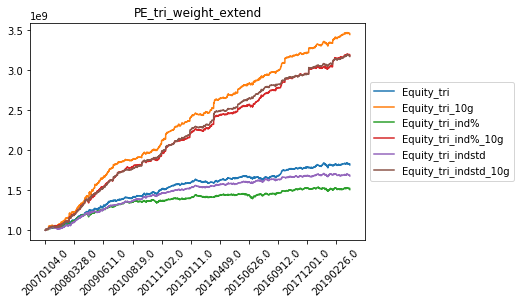

annual return: 0.06452359186996037
annual std: 0.028594729768577718
sharp ratio: 2.0320538762276295
max drawdown: 0.0325686936061773
NP / MDD: 13.629675744348905
odds ratio: 0.5359186268277177
skewness: 0.21555184769721886
annual return: 0.1936170151367294
annual std: 0.03490662402386186
sharp ratio: 5.3628633523746405
max drawdown: 0.02217402660075296
NP / MDD: 42.65744054153295
odds ratio: 0.5556261919898283
skewness: 4.583826452869176
annual return: 0.04014758106109232
annual std: 0.027196547980754996
sharp ratio: 1.2402316897320993
max drawdown: 0.04336743010989547
NP / MDD: 8.032944761171006
odds ratio: 0.5394151303242213
skewness: 0.3382059231394323
annual return: 0.17274667559795281
annual std: 0.03228365082745333
sharp ratio: 5.1521160380185265
max drawdown: 0.03097300748506865
NP / MDD: 50.977219253323916
odds ratio: 0.5670692943420216
skewness: 4.567946605845393
annual return: 0.05377840288082357
annual std: 0.02456854908544443
sharp ratio: 1.9277020515974195
max drawdown: 0.

In [524]:
for f in range(len(factor_list)):
    factor  = factor_list[f]

    df_tri = pd.read_csv('./Stats_Detail_New/'+factor+'_Stats_Detail_New_'+'tri'+'.txt')
    df_tri_10g = pd.read_csv('./Stats_Detail_New/'+factor+'_Stats_Detail_New_'+'tri_10g'+'.txt')
    df_tri_ind_perc = pd.read_csv('./Stats_Detail_New/'+factor+'_Stats_Detail_New_'+'tri_ind%'+'.txt')
    df_tri_ind_perc_10g = pd.read_csv('./Stats_Detail_New/'+factor+'_Stats_Detail_New_'+'tri_ind%_10g'+'.txt')
    df_tri_ind_std = pd.read_csv('./Stats_Detail_New/'+factor+'_Stats_Detail_New_'+'tri_indstd'+'.txt')
    df_tri_ind_std_10g = pd.read_csv('./Stats_Detail_New/'+factor+'_Stats_Detail_New_'+'tri_indstd_10g'+'.txt')
    x = np.arange(len(df_tri))
    plt.plot(df_tri['Equity_'+'tri'],label='Equity_'+'tri')
    plt.plot(df_tri_10g['Equity_'+'tri_10g'],label='Equity_'+'tri_10g')
    plt.plot(df_tri_ind_perc['Equity_'+'tri_ind%'],label='Equity_'+'tri_ind%')
    plt.plot(df_tri_ind_perc_10g['Equity_'+'tri_ind%_10g'],label='Equity_'+'tri_ind%_10g')
    plt.plot(df_tri_ind_std['Equity_'+'tri_indstd'],label='Equity_'+'tri_indstd')
    plt.plot(df_tri_ind_std_10g['Equity_'+'tri_indstd_10g'],label='Equity_'+'tri_indstd_10g')
    date = df_tri['Date']

    plt.xticks(x[::300],labels=date[::300],rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(factor+'_tri_weight_extend')
    plt.savefig('./Graph_new/'+factor+'_tri_weight_extend.jpg', bbox_inches='tight')
    plt.show()
    
    df_RM=pd.read_excel('Data/3.Rm_Rf/2007-201909Rm.xlsx')
    df_RM.columns = df_RM.iloc[3,]
    df_RM=df_RM.drop([0,1,2,3])
    df_RM=df_RM.dropna(axis=1).reset_index(drop=True)
    df_RM.columns = ['Date','大盤指數']
    df_RM['Date'] = [datetime.strftime(x,format='%Y%m%d') for x in df_RM['Date'] ]
    df_RM=df_RM.sort_values('Date').drop_duplicates()
    df_RM['Rm'] = df_RM['大盤指數'].pct_change() 



    df_RF=pd.read_excel('Data/3.Rm_Rf/2009-201909Rf.xlsx')
    df_RF.columns = df_RF.iloc[3,]
    df_RF=df_RF.drop([0,1,2,3])
    df_RF=df_RF.dropna(axis=1).reset_index(drop=True)
    df_RF.columns = ['Date','Rf']
    df_RF['Date'] = [datetime.strftime(x,format='%Y%m%d') for x in df_RF['Date'] ]
    df_RF=df_RF.sort_values('Date').drop_duplicates()
    E_RF = df_RF['Rf'].mean()/100

    Factors_list = []
    LongBig_list = []
    Weight_Method_list = ['tri','tri_10g','tri_ind%','tri_ind%_10g',
                          'tri_indstd','tri_indstd_10g']
    CAGR_list = []
    STD_Y_list = []
    Sharp_ratio_list = []
    mdd_list = []
    NP_MDD_list = []
    Odd_list = []
    skew_list = []
    Tornover_list = []

    data_list = [df_tri,df_tri_10g,df_tri_ind_perc,df_tri_ind_perc_10g,df_tri_ind_std,df_tri_ind_std_10g]

    for i in range(len(data_list)):

        equity = pd.DataFrame(data_list[i]['Equity_'+Weight_Method_list[i]])
        CAGR,STD_Y,Sharp_ratio,mdd,NP_MDD,Odd,skew = performance_stats(equity,E_RF=E_RF)
        CAGR_list.append(CAGR)
        STD_Y_list.append(STD_Y)
        Sharp_ratio_list.append(Sharp_ratio)
        mdd_list.append(mdd[0])
        NP_MDD_list.append(NP_MDD[0][0])
        Odd_list.append(Odd[0])
        skew_list.append(skew[0])
        Factors_list.append( Factor_args[Main_Factor_Name]['factors'][0])
        LongBig_list.append( Factor_args[Main_Factor_Name]['longbig'][0])
        Tornover_list.append(np.mean([x for x in data_list[i]['Turnover_'+Weight_Method_list[i]] if np.isnan(x)==False]))


    df_factor_stat = pd.DataFrame()
    df_factor_stat['Factors']       = Factors_list
    df_factor_stat['LongBig']       = LongBig_list
    df_factor_stat['Weight_Method']       = Weight_Method_list                         
    df_factor_stat['Return_annual'] = CAGR_list
    df_factor_stat['Std_annual'] = STD_Y_list
    df_factor_stat['Sharp']         = Sharp_ratio_list
    df_factor_stat['mdd']        = mdd_list
    df_factor_stat['NP_MDD']     = NP_MDD_list
    df_factor_stat['Odds']          = Odd_list
    df_factor_stat['Turnover']          = Tornover_list
    df_factor_stat['Skew']          = skew_list
    df_factor_stat.round(4)
    #df_factor_stat.to_csv('./stats/'+factor+".csv",index=False)
    df_factor_stat